In [1]:
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
# import plotly.graph_objs as go
# import plotly.express as px
# from plotly.subplots import make_subplots
import numpy as np
import seaborn as sns
import scanpy as sc
import gseapy
from datetime import datetime
from lifelines.utils import restricted_mean_survival_time
from lifelines.statistics import logrank_test,multivariate_logrank_test
from lifelines import KaplanMeierFitter
import lifelines 
import statsmodels
from scipy.stats import rankdata
import math
from sklearn.preprocessing import scale

In [2]:
sc.set_figure_params(figsize=(5, 5), dpi=100, fontsize=20)
sns.set_style("whitegrid", {'axes.grid' : False})

def km_plot_multi(df_info, category, os, event, title=''):
    
    kmf = lifelines.KaplanMeierFitter()
    plt.figure(figsize=(8,4))
    ax = plt.gca()
    category_vals = list(df_info[category].unique())
    #val_str = '/'.join(category_vals)
    
    
    for val in category_vals:
        m = df_info[category] == val
        count = sum(m)
        label = "{} (n={})".format(val,count)
        T_exp, E_exp = df_info.loc[m,os], df_info.loc[m,event]
        kmf.fit(T_exp, E_exp, label=label)
        ax = kmf.plot_survival_function(ci_show=False, linewidth=3,)
        

    result = multivariate_logrank_test(df_info[os], df_info[category], df_info[event])
    p_val="{:.2e}".format(result.p_value)
    plt.text(0, 0.01, 'p-value: {}'.format(p_val), fontsize=15)
    if title=='':
        title = 'KM Plot - {}'.format(category)
        
    plt.title(title, fontsize=20)
    plt.xlabel('OS(month)',fontsize=15)
    plt.ylabel('Overall Survival',fontsize=15)
    plt.ylim(-0.1,1.1)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()
    

def km_plot_bi(df_info, category, os, event):
    category_vals = list(df_info[category].unique())
    
    for val in category_vals:
        kmf = lifelines.KaplanMeierFitter()
        plt.figure(figsize=(8,4))
        ax = plt.gca()
        
        m = df_info[category] == val
        T_test, E_test = df_info.loc[m,'OS'], df_info.loc[m,'death2']
        t_count = T_test.shape[0]
        T_control, E_control = df_info.loc[~m, 'OS'], df_info.loc[~m, 'death2']
        c_count = T_control.shape[0]
        
        kmf.fit(T_test, E_test, label='{} (n={})'.format(val, t_count))
        ax = kmf.plot_survival_function(ci_show=False, linewidth=3,)
        
        kmf.fit(T_control, E_control, label='Rest (n={})'.format(c_count))
        ax = kmf.plot_survival_function(ax=ax,ci_show=False, linewidth=3,)
        
        plt.legend(loc='upper right')
        t_res = logrank_test(T_test, T_control, event_observed_A=E_test, event_observed_B=E_control, alpha=.95)
        p_val="{:.2e}".format(t_res.p_value)
        
        
        plt.text(0, 0.01, 'p-value: {}'.format(p_val),fontsize=15)
        title = 'KM Plot - {} vs Rest'.format(val)
        plt.title(title, fontsize=20)
        plt.xlabel('OS(month)',fontsize=15)
        plt.ylabel('Overall Survival',fontsize=15)
        plt.legend(fontsize=15)
        plt.ylim(-0.1,1.1)
        plt.grid()
        plt.show()

def category_count_plot(df_mg,col_sel):
    val_counts_dict = dict()
    PC_clinical_data_sel = df_mg.loc[:,col_sel]
    for col in col_sel:
        counter = dict(Counter(PC_clinical_data_sel[col]).most_common())
        val_counts_dict[col] = counter
    
    print(val_counts_dict)
    
    sns.set(rc={'figure.figsize':(4,3), "figure.dpi":100, 'savefig.dpi':100})
    sns.set_style("ticks")

    titles = list(val_counts_dict.keys())
    

    for title in titles:
        labels = list(val_counts_dict[title].keys())
        fracs = list(val_counts_dict[title].values())
        
        
        #print(labels)
        
        if np.nan in labels:
            h_size = (len(labels)-1)*0.5
        else:
            h_size = len(labels)*0.5
        

        sns.set(rc={'figure.figsize':(4,h_size)})
        sns.set_style("ticks")
        sns.barplot(x=fracs,y=labels,palette=sns.color_palette("hls", 8))
        plt.title(title,fontsize=18)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=12)
        plt.show()
        
def scatter_plot(df, x, y, hue=None):
    pearsonr_res = scipy.stats.pearsonr(df[x], df[y])
    p_r,p_p = pearsonr_res[0],pearsonr_res[1]
    
    spearmanr_res = scipy.stats.spearmanr(df[x], df[y])
    s_r,s_p = spearmanr_res[0],spearmanr_res[1]
    
    text1 = 'Pearson:\n R={:.4f}, p-val={:.2e}'.format(p_r,p_p)
    text2 = 'Spearman:\n R={:.4f}, p-val={:.2e}'.format(s_r,s_p)
    
    sns.set(rc={'figure.figsize':(3,3), "figure.dpi":100, 'savefig.dpi':100})
    sns.set_style("ticks")
    sns.scatterplot(data=df, x=x, y=y, hue=hue, alpha=0.5, color='red')
    
    title = '{} and {}'.format(x, y)
    plt.title(title)
    diff = (df[x].max()-df[x].min())/10
    x_pos = df[x].min()+diff
    y_pos = df[y].min()
    plt.text(x_pos, y_pos, text1,fontsize=10)
    #plt.text(8, 0.7, text2,fontsize=10)
    
    plt.show()


def Count2TPM(df):
    all_sum = df.sum()
    multi = 1000000/all_sum
    return df*multi
def idx_mapping(x):
    return 'Patient{}'.format(x)
def str_replace(x):
    return x.replace('_',' ')

# 1. Merge Clinical and Gene Expression Data (Scanpy AnnData Format)

In [241]:
# df_exp = pd.read_csv('/mnt/HDD1/Work_SNU_JoongHo/STAR2pass_Merged_expression_TPM/Genes_TPM.csv', index_col=0)
# patients = list(df_exp.index)
# df_exp

In [242]:
# df_clinical = pd.read_csv('/mnt/HDD1/Work_SNU_JoongHo/1.ClinicalData_Cleaning/Clinical_20220519_clean.csv',index_col='Snubh_TB')
# df_clinical.drop('Unnamed: 0', axis=1, inplace=True)
# df_clinical_sel = df_clinical.loc[patients,:]
# df_clinical_sel

In [243]:
# adata = sc.AnnData(df_exp)
# adata.obs = df_clinical_sel
# adata.write('SNU_AnnDataForm_20220519.h5ad')

# Data Analysis

In [244]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm_20220814.h5ad')
sc.pp.log1p(SNU_adata)
SNU_genes = list(SNU_adata.to_df().columns)

In [245]:
m = ~SNU_adata.to_df().columns.str.startswith('MT-')
SNU_adata = SNU_adata[:,m]
SNU_adata

View of AnnData object with n_obs × n_vars = 93 × 19974
    obs: 'N0', 'PID', 'dateA', 'Snubh_BB', 'pathology_number', 'tumorcellularity(pathology)', 'DNA_RNA', 'methylSeq', 'metagenomic', 'liquid_number', 'liguid_timing', 'KRAS_mutation_WES', 'KRAS_VAF', 'KRAS_mutation_WTS', 'KRAS_final', 'cfDNA', 'liquid_KRAS', 'R_ul', 'R_DNA', 'cellularity', 'MSI', 'pathology', 'dateA.1', 'stageA', 'CTx', 'neo_response', 'Op_date', 'R', 'LN', 'CAP_score', 'TNM', 'recur', 'recur_date', 'Liver_recur', 'Lung_recur', 'PS_recur', 'other_recur', 'multiple_recur', 'RFS', 'postrecur_CTx', 'chemo', 'CTxBOR', 'RTx_effect', 'PD', 'PD_date', 'Localizd_tumor', 'Liver_PD', 'Lung_PD', 'PS_PD', 'other_PD', 'multiple_PD', 'PFS', 'Unnamed:53', 'Unnamed:54', 'metsA1', 'metsA2', 'metsA3', 'LN.1', 'metsA4', 'metsA5', 'EOPC', 'stage', 'stage_A', 'Mets_liver', 'Mets_lung', 'Mets_PS', 'primary_tumor_location', 'cellularity_path', 'stage_B', 'stage_C', 'Mets_liver_C', 'Mets_lung_C', 'Mets_PS_C', 'CTx_type', '1st_PD', '2ndli

In [246]:
N_pca = 40
sc.tl.pca(SNU_adata, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(SNU_adata, n_neighbors=15, n_pcs=N_pca)
sc.tl.umap(SNU_adata)

# Data UMAP Visualization

## All gene

In [247]:
feature = ['stage_A', 'stage_B', 'stage_C', 'Mets_liver', 'Mets_lung', 'Mets_PS', 'CTx_response_FFX', 'CTx_response_GNP', 
           'Mets_liver_C','Mets_lung_C','Mets_PS_C']

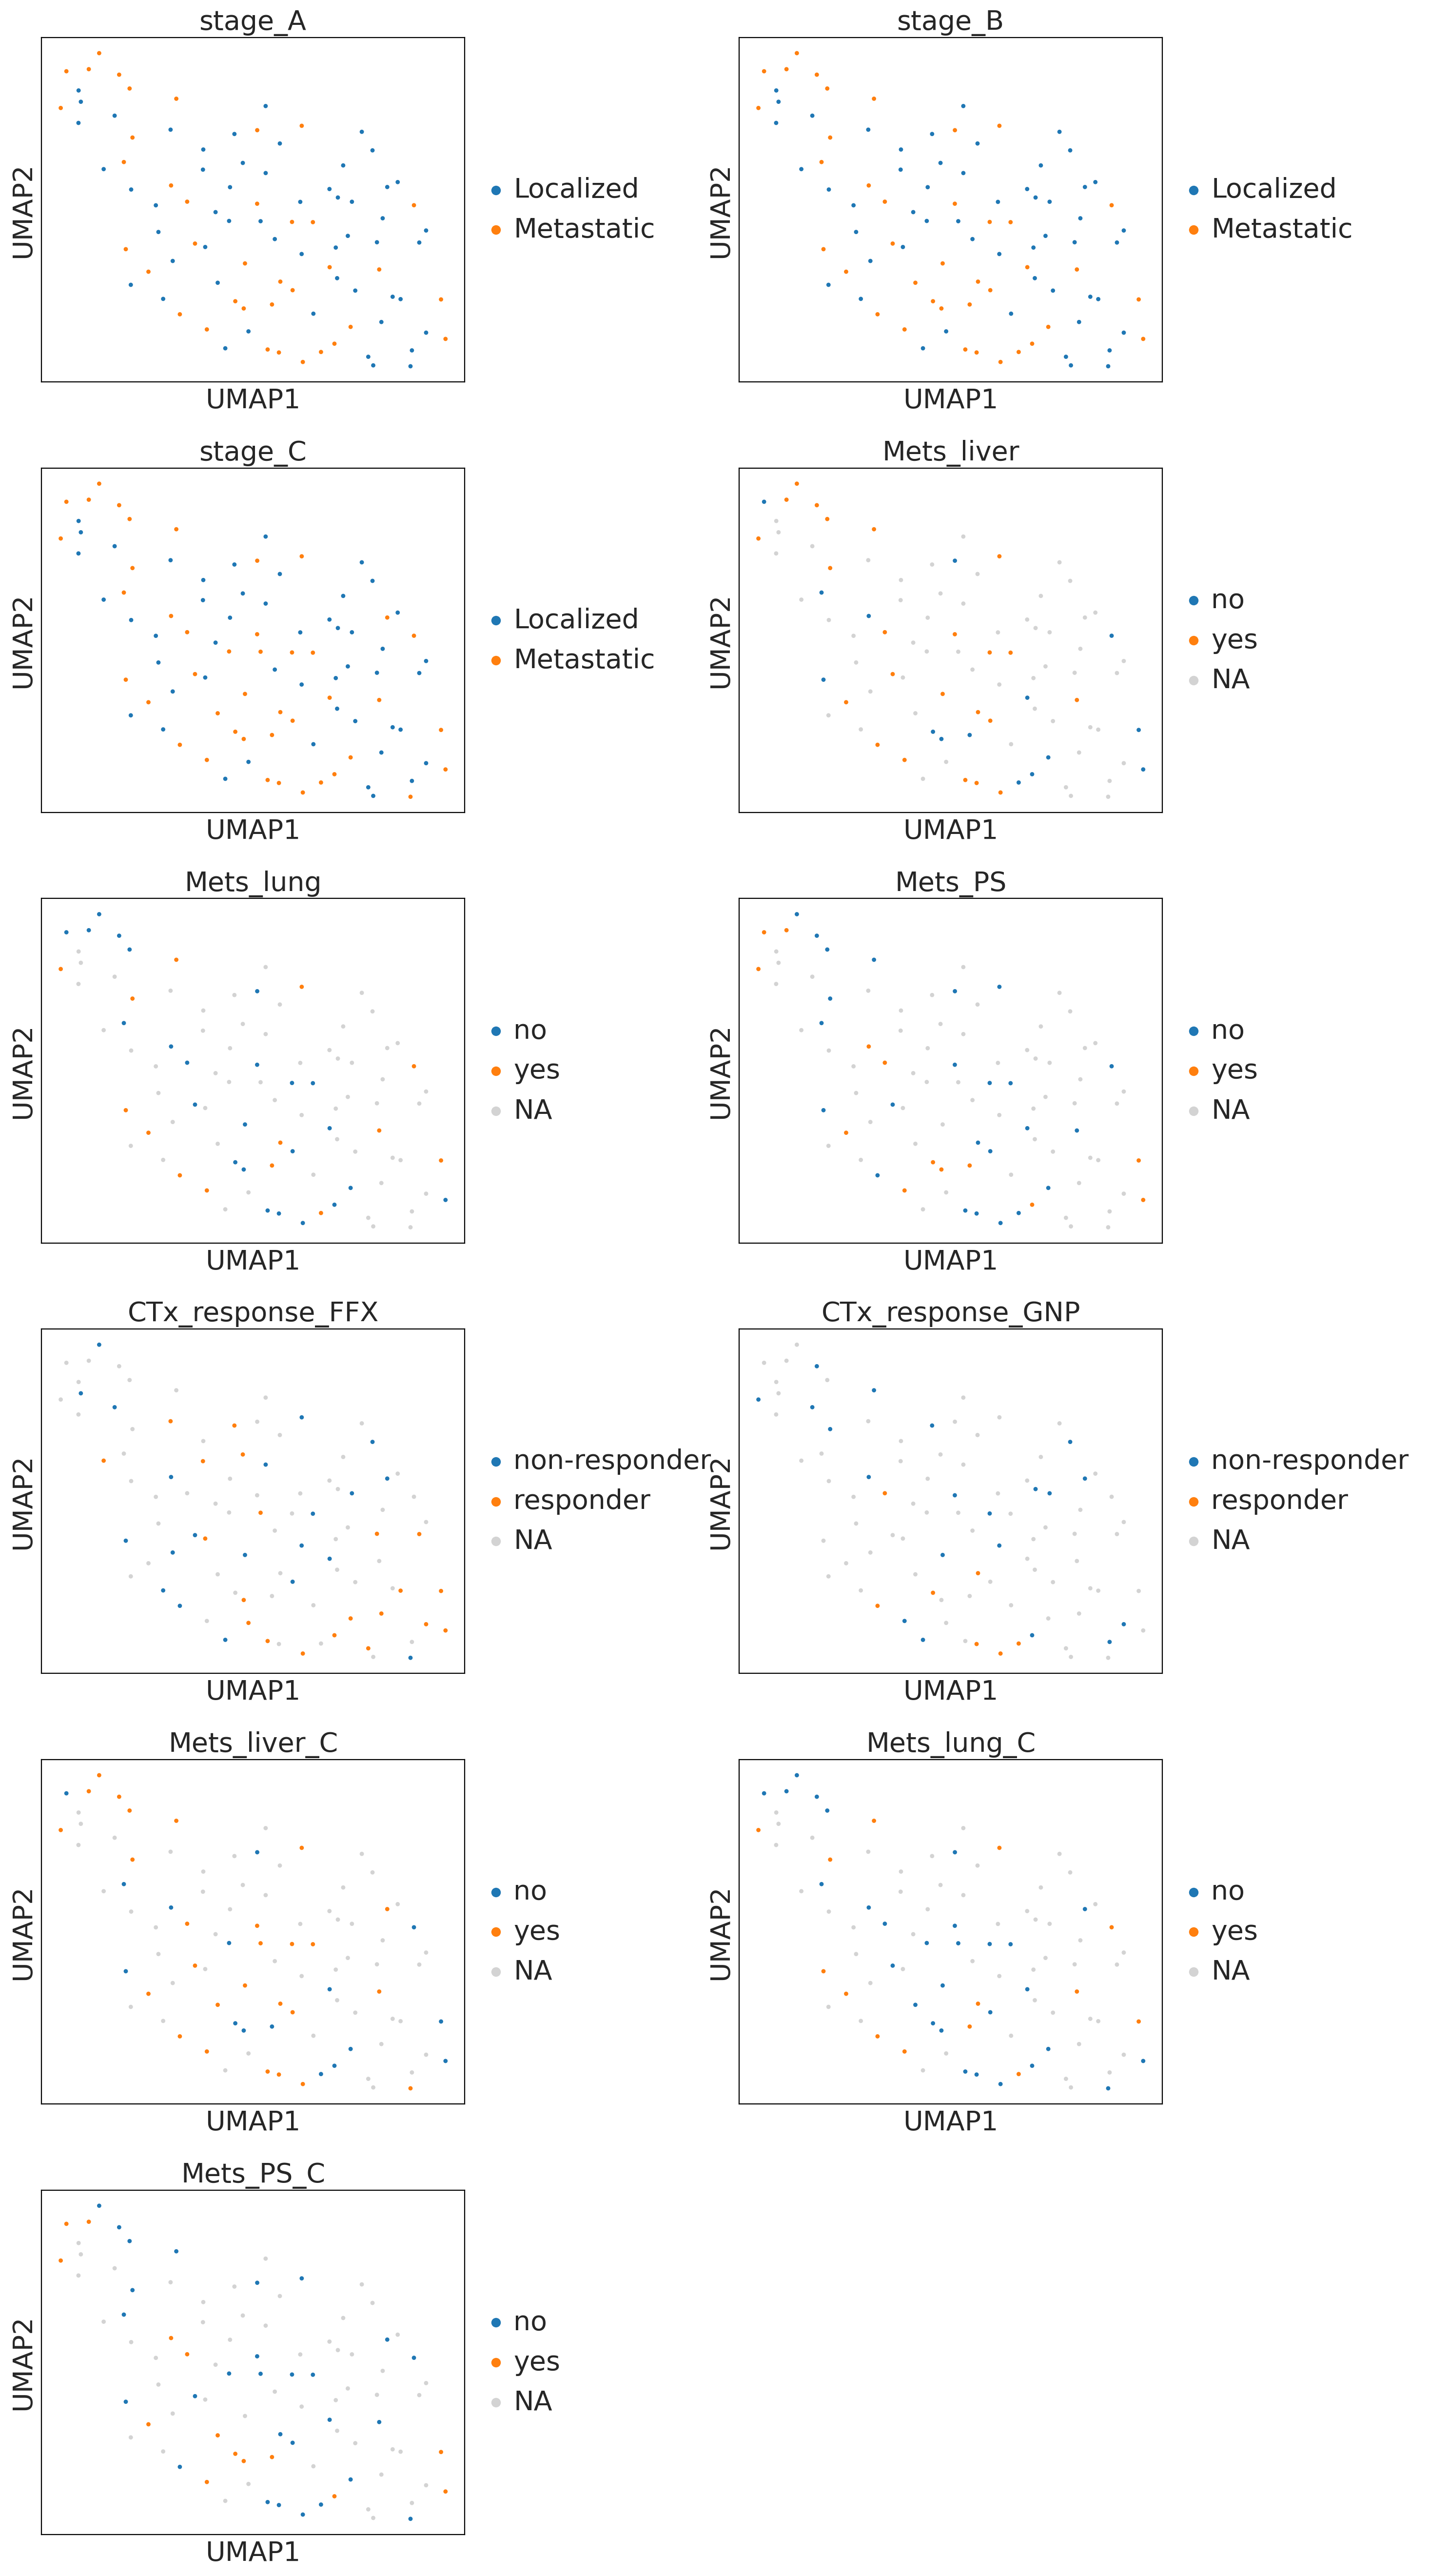

In [248]:
sc.set_figure_params(figsize=(5, 5), dpi=100, fontsize=20)
sc.pl.umap(SNU_adata, color=feature, s = 40, ncols=2, wspace=0.5, legend_fontsize = 20)

In [249]:
# sc.pp.highly_variable_genes(SNU_adata,n_top_genes=1000)
# SNU_adata_sel = SNU_adata[:,SNU_adata.var.highly_variable]
# N_pca = 40
# sc.tl.pca(SNU_adata_sel, svd_solver='arpack', n_comps = N_pca)
# sc.pp.neighbors(SNU_adata_sel, n_neighbors=15, n_pcs=N_pca)
# sc.tl.umap(SNU_adata_sel)

# sc.settings.set_figure_params(dpi=100)
# sc.pl.umap(SNU_adata_sel, color=col_sel, s = 40, ncols=2, wspace=0.3, legend_fontsize = 10)

In [250]:
feature = ['stage_A', 'stage_B', 'stage_C', 'Mets_liver', 'Mets_liver_C', 'Mets_lung', 'Mets_lung_C', 'Mets_PS', 'Mets_PS_C', 
           'CTx_response_FFX', 'CTx_response_GNP']

In [251]:
res_save_folder = './DEG_Res'
if not os.path.isdir(res_save_folder):
    os.mkdir(res_save_folder)
    
feature   

['stage_A',
 'stage_B',
 'stage_C',
 'Mets_liver',
 'Mets_liver_C',
 'Mets_lung',
 'Mets_lung_C',
 'Mets_PS',
 'Mets_PS_C',
 'CTx_response_FFX',
 'CTx_response_GNP']

# DEG

In [252]:
target_group = feature[9]
test = SNU_adata.obs[target_group].cat.categories[0]
print('test: {}'.format(test))
control = SNU_adata.obs[target_group].cat.categories[1]
print('control: {}'.format(control))

test_method = 't-test' # wilcoxon / t-test
groups = [test, control]
sc.tl.rank_genes_groups(SNU_adata, target_group, groups=[test], reference=control, method=test_method)

result = SNU_adata.uns['rank_genes_groups']
df_deg = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_deg[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_deg = df_deg.sort_values(by='pvals')
m = df_deg['pvals'] < 0.05
df_deg = df_deg[m]
sv_file = os.path.join(res_save_folder,'DEG_{}_{}.csv'.format(target_group,test_method))
df_deg.to_csv(sv_file)
print('{}'.format(sum(df_deg['pvals_adj']<0.05)))
df_deg

test: non-responder
control: responder
0


logfoldchanges     pvals  pvals_adj    scores
AL357673.1       -1.459805  0.000006   0.053231 -5.248516
CCDC30           -1.235180  0.000011   0.053231 -5.012580
ANKRD18A.1       -1.737689  0.000015   0.053231 -5.004241
ATXN7L1          -0.723265  0.000015   0.053231 -4.923428
FAM24B           -1.224760  0.000017   0.053231 -5.003862
...                    ...       ...        ...       ...
ARL4C             0.626576  0.049875   0.352759  2.024207
RELB             -0.454280  0.049896   0.352759 -2.027598
NR2C2            -0.246359  0.049901   0.352759 -2.023600
KIAA0195         -0.459900  0.049909   0.352759 -2.027144
TRIM17           -0.675076  0.049910   0.352759 -2.022223

[2826 rows x 4 columns]

# Read DEG files

In [347]:
DEG_files = os.listdir(res_save_folder)
DEG_dict = dict()
for file in DEG_files:
    key_ = file.split('.')[0]
    file_dir = os.path.join(res_save_folder,file)
    val = pd.read_csv(file_dir, index_col=0)
    DEG_dict[key_] = val
sorted(DEG_dict.keys())

['DEG_CTx_response_FFX_t-test',
 'DEG_CTx_response_GNP_t-test',
 'DEG_Mets_PS_C_t-test',
 'DEG_Mets_PS_t-test',
 'DEG_Mets_liver_C_t-test',
 'DEG_Mets_liver_t-test',
 'DEG_Mets_lung_C_t-test',
 'DEG_Mets_lung_t-test',
 'DEG_stage_A_t-test',
 'DEG_stage_B_t-test',
 'DEG_stage_C_t-test']

In [348]:
dkey = 'DEG_'+target_group+'_t-test'

df_deg = DEG_dict[dkey]

m = df_deg['logfoldchanges'] > 0
up_genes = list(df_deg[m].index)[:100]
down_genes = list(df_deg[~m].index)[:100]

df_deg

logfoldchanges         pvals  pvals_adj    scores
HGS            -1.137734  6.590118e-07   0.013163 -6.994936
C17orf70       -0.921701  2.064941e-06   0.020623 -6.138765
PIEZO1         -1.108968  5.152072e-06   0.034302 -5.789153
FAM24B         -1.309056  7.097693e-06   0.035442 -5.649993
HELLS          -0.954586  1.558411e-05   0.050005 -5.348223
...                  ...           ...        ...       ...
ARMCX6         -0.387520  4.980698e-02   0.349436 -2.070535
PAX1           26.121914  4.993750e-02   0.350229  2.093656
GVQW1          -0.836029  4.998119e-02   0.350237 -2.247104
CKMT2          -0.897577  4.998520e-02   0.350237 -2.119053
TXNDC8         25.954890  4.999823e-02   0.350237  2.093042

[2851 rows x 4 columns]

In [349]:
# sc.set_figure_params(figsize=(10, 10), dpi=100, fontsize=20)

# m = ~SNU_adata.obs[target_group].isna()
# SNU_adata_sel = SNU_adata[m]
# genes = up_genes[:50]+down_genes[:50]

# sc.pl.rank_genes_groups_heatmap(SNU_adata_sel, var_names=genes, groupby=target_group, show_gene_labels=True)
# #sc.pl.rank_genes_groups_heatmap(SNU_adata_sel, n_genes=50, groupby=target_group, show_gene_labels=True)


# GSEA

In [3]:
# gene_set_names = gseapy.get_library_name(organism='Human')
# print(gene_set_names)

In [4]:
import matplotlib.patches as mpatches
import textwrap


def PS_plot(df, test, control, ytickwidth=0.65, title=''):
    
    try:
        palette ={"Up-regulated": "#f54922", "Down-regulated": "#2261f5"}
        red_patch = mpatches.Patch(color='#f54922', label=test)
        blue_patch = mpatches.Patch(color='#2261f5', label=control)
        sorting_args = ['Type', 'Pathway-Score(Negative Log)']    
        df = df.sort_values(by=sorting_args,ascending = [False]*len(sorting_args))
        df_sel = df.iloc[:15,:]
        colors = list(df_sel['Type'].map(palette))
        ylen = df_sel.shape[0]
        plt.figure(figsize=(10,ylen*ytickwidth), dpi=100)
        ax = sns.barplot(x="Pathway-Score(Negative Log)", y="Pathways",
                    data=df_sel, color="salmon", saturation=.9, palette=colors)
        f = lambda x: textwrap.fill(x.get_text(), 55)
        ax.set_yticklabels(map(f, ax.get_yticklabels()))
        plt.legend(handles=[red_patch, blue_patch],loc='lower right', fontsize=12)
        #ax.legend(loc='lower right', labels=["Up-regulated","Down-regulated"], fontsize=15)
        plt.title(title,fontsize=18)
        plt.yticks(fontsize=12)
        plt.xlabel('Pathway-Score(Negative Log)', fontsize=15)
        plt.ylabel('')
        #plt.xlim((0,15))
        plt.tight_layout()
        plt.show()
    except:
        print('Cannot show figure')
    return df_sel


def Term_name(df):
    if df['Gene_set'].find('GO_Bio') == -1:
        return '{}\n({})'.format(df['Term'], df['Gene_set'])
    else:
        return '{}'.format(df['Term'])
    

def ln(x):
    return -np.log(x)

def GSEA_custom(gene_list, dataset_list, organism='Human', adj_p_threshold=0.05):
    
    enr_res = gseapy.enrichr(gene_list=gene_list,organism=organism,
                         gene_sets=dataset_list,description='pathway', cutoff = 0.9)
    gsea_df = enr_res.results
    gsea_df['Pathways'] = gsea_df.apply(Term_name, axis=1)
    gsea_df = gsea_df.sort_values(by='Adjusted P-value')
    m = gsea_df['Adjusted P-value'] < adj_p_threshold
    gsea_df_sel = gsea_df[m]
    gsea_df_sel['Pathway-Score(Negative Log)'] = gsea_df_sel['Adjusted P-value'].map(ln)
    #res_df['-log10 p value'] = res_df['P-value'].map(log10)
    return gsea_df_sel

# def PS_plot(df, title=''):
#     df_sel = df.iloc[:20,:]
#     ylen = df_sel.shape[0]
#     plt.figure(figsize=(8,ylen*0.7))
#     sns.barplot(x="Pathway-Score(Negative Log)", y="Pathways", data=df_sel, color="salmon", saturation=.8)
#     plt.title(title,fontsize=20)
#     plt.yticks(fontsize=15)
#     plt.show()
    

In [352]:
save_folder = './GSEA_Res'
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
    

In [353]:
# ! pip install range-key-dict

In [12]:
test

'non-responder'

/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a 

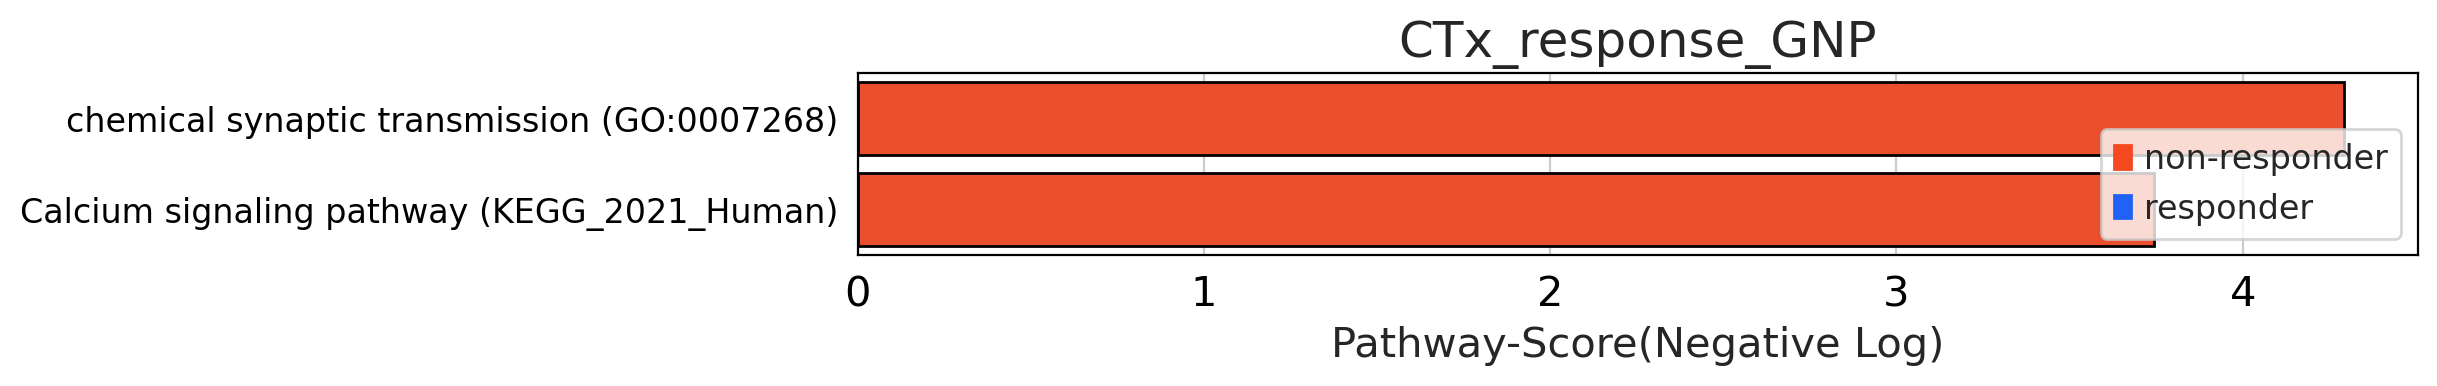

In [354]:
geneset_list = ['MSigDB_Hallmark_2020', 'KEGG_2021_Human', 'GO_Biological_Process_2021', 'Reactome_2016']

gsea_res = GSEA_custom(gene_list=up_genes,dataset_list=geneset_list)
file_dir = os.path.join(save_folder,'GSEA_{}_up.csv'.format(dkey))
gsea_res.to_csv(file_dir)

gsea_res = GSEA_custom(gene_list=down_genes,dataset_list=geneset_list)
file_dir = os.path.join(save_folder,'GSEA_{}_down.csv'.format(dkey))
gsea_res.to_csv(file_dir)

up_df = pd.read_csv(save_folder+'/GSEA_{}_up.csv'.format(dkey),index_col=0)
up_df['Type'] = "Up-regulated"
down_df = pd.read_csv(save_folder+'/GSEA_{}_down.csv'.format(dkey),index_col=0)
down_df['Type'] = "Down-regulated"
df2plot = up_df.append(down_df)
df_sel = PS_plot(df=df2plot, test=test, control=control, ytickwidth=0.60, title='{}'.format(target_group))


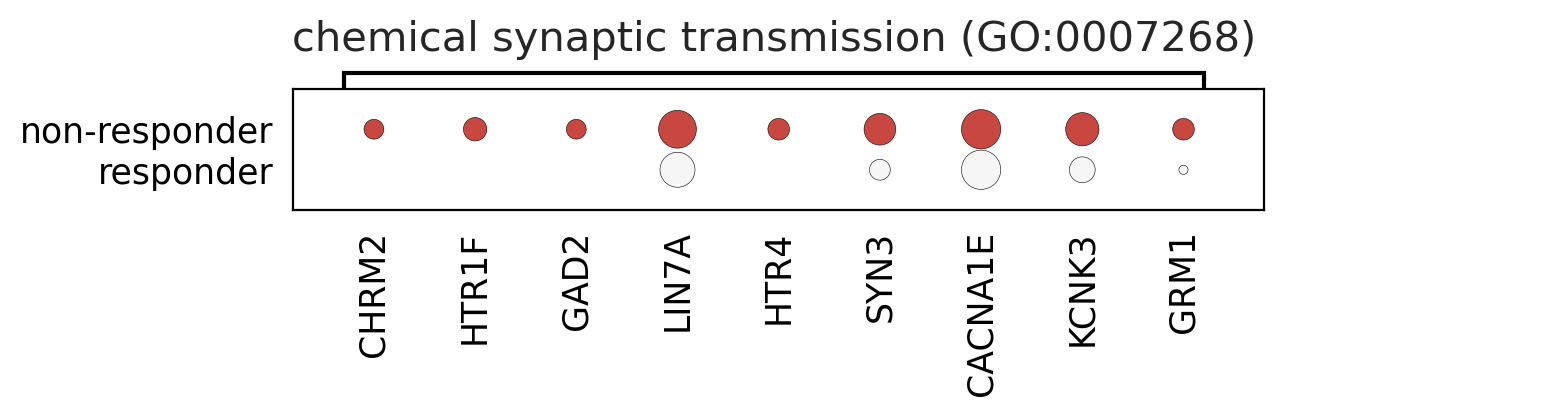

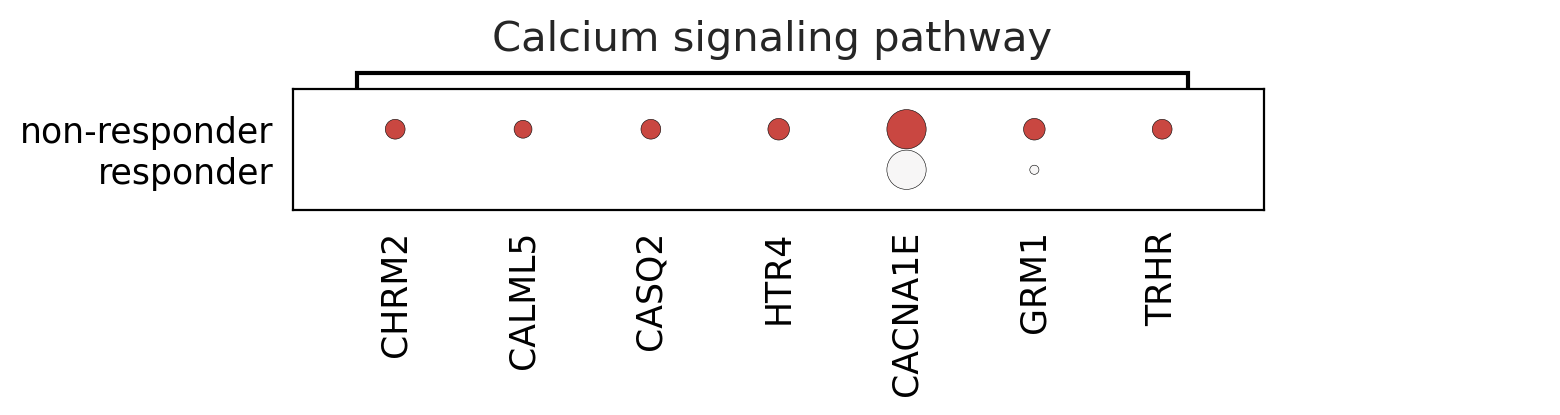

In [355]:
m = ~SNU_adata.obs[target_group].isna()
SNU_adata_sel = SNU_adata[m]

Terms = list(df_sel['Term'])
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(5, 5), facecolor='white', fontsize=15)
matplotlib.rcParams['patch.edgecolor'] = 'black'

pathway_geneset_dict = dict()
for term in Terms:
    m = df_sel['Term'] == term
    geneset = [gene for gene in df_sel.loc[m,'Genes'].values.item().split(';')]
    title = textwrap.fill(term, 45)
    ax = sc.pl.dotplot(SNU_adata, {title:geneset}, target_group,
                    dendrogram=False, var_group_rotation=0, figsize=(8,0.8), standard_scale='var', swap_axes=False,
                  vmin=-1.5, vmax=1.5, return_fig=True).style(cmap='RdBu_r')
    axes_dict = ax.get_axes()
    axes_dict['size_legend_ax'].set_visible(False)
    axes_dict['color_legend_ax'].set_visible(False)
    plt.show()




In [284]:
# m = ~SNU_adata.obs[target_group].isna()
# SNU_adata_sel = SNU_adata[m]

# Terms = list(df_sel['Term'])[:6]
# sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(10, 8), facecolor='white', fontsize=15)
# matplotlib.rcParams['patch.edgecolor'] = 'black'

# pathway_geneset_dict = dict()
# for term in Terms:
#     m = df_sel['Term'] == term
#     geneset = [gene for gene in df_sel.loc[m,'Genes'].values.item().split(';')]
#     title = textwrap.fill(term, 30)
#     pathway_geneset_dict[title] = geneset


# ax = sc.pl.dotplot(SNU_adata, pathway_geneset_dict, target_group,
#                     dendrogram=False, var_group_rotation=90, figsize=(25,3), standard_scale='var', swap_axes=False,
#                   vmin=-1.5, vmax=1.5, return_fig=True).style(cmap='RdBu_r')

# axes_dict = ax.get_axes()
# axes_dict['size_legend_ax'].set_visible(False)
# axes_dict['color_legend_ax'].set_visible(False)



# for term in Terms:
#     m = df_sel['Term'] == term
#     geneset = [gene for gene in df_sel.loc[m,'Genes'].values.item().split(';')]
#     title = term
    
#     ax = sc.pl.dotplot(SNU_adata, {title+' - {}'.format(target_group): geneset}, target_group, 
#                       dendrogram=False, var_group_rotation=0, figsize=(4,4), standard_scale='var',
#                        vmin=-1.5, vmax=1.5,
#                        return_fig=True, show=False).style(cmap='RdBu_r').legend(width=3)
#     axes_dict = ax.get_axes()
#     axes_dict['mainplot_ax'].set_visible(False)
#     axes_dict['gene_group_ax'].set_visible(False)
#     axes_dict['size_legend_ax'].set_title('Fraction of expressions\nin group (%)')
#     #axes_dict['size_legend_ax'].title = {'center':'Fraction of expressions\\nin group'}
#     break





# Subtype Geneset GSEA

In [6]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm.h5ad')
sc.pp.log1p(SNU_adata)

res_save_folder = './DEG_Res'
if not os.path.isdir(res_save_folder):
    os.mkdir(res_save_folder)

SNU_adata.obs

N0       PID       dateA         Snubh_BB  \
Snubh_TB                                                         
20-T00330_FO-01  sb2441  32644755  2020-05-15  20-B01156_EB-03   
19-T00062_FO-01  sb1947  10108754  2019-03-18  19-B00635_EB-03   
20-T00814_FT-01  sb2669  33563897  2020-12-16  20-B04522_EB-04   
19-T00201_FO-01  sb2097  24118798  2019-05-27              NaN   
19-T00505_FO-01  sb2298  31651231  2019-09-09  19-B02081_EB-03   
...                 ...       ...         ...              ...   
21-T00576_FT-01     NaN  10805327  2021-07-23              NaN   
19-T00620_FO-01  sb2342  31927356  2019-10-30  19-B02516_EB-03   
19-T00413_FO-01  sb2283  31464792  2019-08-06  19-B01826_EB-03   
20-T00073_FO-01  sb1988  11769796  2020-02-03  20-B00280_EB-03   
19-T00119_FO-01  sb2223  30981162  2019-04-30              NaN   

                pathology_number tumorcellularity(pathology)  DNA_RNA  \
Snubh_TB                                                                
20-T00330_FO-01      S 200019390                          25  DNA+RNA   
19-T00062_FO-01      S 190013089                          45  DNA+RNA   
20-T00814_FT-01      S 200053444                          35  DNA+RNA   
19-T00201_FO-01      S 190025387                          40      RNA   
19-T00505_FO-01      S 190043830                          50  DNA+RNA   
...                          ...                         ...      ...   
21-T00576_FT-01      S 210032997                         NaN      RNA   
19-T00620_FO-01      S 190052008                          35  DNA+RNA   
19-T00413_FO-01      S 190038136                          20  DNA+RNA   
20-T00073_FO-01      S 200005133                          45  DNA+RNA   
19-T00119_FO-01      S 190021043                           5      RNA   

                 methylSeq  metagenomic liquid_number  ...  OS_F stage_2  \
Snubh_TB                                               ...                 
20-T00330_FO-01        NaN          NaN          R167  ...  26.7     NaN   
19-T00062_FO-01        NaN          NaN           NaN  ...   7.2     NaN   
20-T00814_FT-01        NaN          NaN          R201  ...   8.3     NaN   
19-T00201_FO-01        NaN          NaN          R017  ...  25.9     NaN   
19-T00505_FO-01        NaN          NaN          R074  ...  34.4     NaN   
...                    ...          ...           ...  ...   ...     ...   
21-T00576_FT-01        NaN          NaN           NaN  ...   5.1     NaN   
19-T00620_FO-01        NaN          NaN          R106  ...   2.2     NaN   
19-T00413_FO-01        NaN          NaN           NaN  ...  36.2     NaN   
20-T00073_FO-01        NaN          NaN           NaN  ...  15.6     NaN   
19-T00119_FO-01        NaN          NaN           NaN  ...  17.2     NaN   

                 Tumor Subtype TME Subtype  Moffitt Subtype  \
Snubh_TB                                                      
20-T00330_FO-01             C2          E1        BasalLike   
19-T00062_FO-01             C2          E1        BasalLike   
20-T00814_FT-01             C1          E1        BasalLike   
19-T00201_FO-01             C2          E2        BasalLike   
19-T00505_FO-01             C1          E1        Classical   
...                        ...         ...              ...   
21-T00576_FT-01             C1          E1        Classical   
19-T00620_FO-01             C2          E1        BasalLike   
19-T00413_FO-01             C1          E2        Classical   
20-T00073_FO-01             C2          E1        BasalLike   
19-T00119_FO-01             C1          E2        Classical   

                        Bailey Subtype  Chan-Seng-Yue Subtype  \
Snubh_TB                                                        
20-T00330_FO-01               Squamous            BasalLike-B   
19-T00062_FO-01                   ADEX            BasalLike-A   
20-T00814_FT-01  Pancreatic Progenitor            Classical-B   
19-T00201_FO-01               Squamous                 Hybrid   
19-T00505_FO-

In [39]:
['Tumor Subtype','TME Subtype']
target_group = 'TME Subtype'

test = SNU_adata.obs[target_group].cat.categories[0]
print('test: {}'.format(test))
control = SNU_adata.obs[target_group].cat.categories[1]
print('control: {}'.format(control))

test_method = 't-test' # wilcoxon / t-test
groups = [test, control]
sc.tl.rank_genes_groups(SNU_adata, target_group, groups=[test], reference=control, method=test_method)

result = SNU_adata.uns['rank_genes_groups']
df_deg = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_deg[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_deg = df_deg.sort_values(by='pvals')
m = df_deg['pvals'] < 0.05
df_deg = df_deg[m]
sv_file = os.path.join(res_save_folder,'DEG_{}_{}.csv'.format(target_group,test_method))
df_deg.to_csv(sv_file)
print('{}'.format(sum(df_deg['pvals_adj']<0.05)))
df_deg

test: E1
control: E2
1822


logfoldchanges         pvals     pvals_adj     scores
MS4A14          2.352552  4.246947e-19  8.488373e-15  11.464903
NCKAP1L         1.838622  2.674053e-16  2.672315e-12  11.626183
MYO1G           1.736668  1.574306e-14  1.048855e-10  10.133415
MS4A6A          1.682815  3.639553e-13  1.818594e-09   9.532481
RASAL3          1.655138  1.920640e-12  6.688772e-09   8.524631
...                  ...           ...           ...        ...
TMEM257        25.821754  4.986254e-02  2.273086e-01   1.995669
USP5           -0.270353  4.986983e-02  2.273086e-01  -2.013247
C12orf49       -0.404971  4.995712e-02  2.276546e-01  -2.023230
GABRG3         26.038454  4.997448e-02  2.276818e-01   1.994666
PPRC1          -0.299070  4.999420e-02  2.277197e-01  -2.021351

[4388 rows x 4 columns]

In [40]:
DEG_files = os.listdir(res_save_folder)
DEG_dict = dict()
for file in DEG_files:
    key_ = file.split('.')[0]
    file_dir = os.path.join(res_save_folder,file)
    val = pd.read_csv(file_dir, index_col=0)
    DEG_dict[key_] = val
sorted(DEG_dict.keys())

['DEG_CTx_response_FFX_t-test',
 'DEG_CTx_response_GNP_t-test',
 'DEG_Mets_PS_C_t-test',
 'DEG_Mets_PS_t-test',
 'DEG_Mets_liver_C_t-test',
 'DEG_Mets_liver_t-test',
 'DEG_Mets_lung_C_t-test',
 'DEG_Mets_lung_t-test',
 'DEG_TME Subtype_t-test',
 'DEG_TMEType_t-test',
 'DEG_Tumor Subtype_t-test',
 'DEG_TumorType_t-test',
 'DEG_stage_A_t-test',
 'DEG_stage_B_t-test',
 'DEG_stage_C_t-test']

In [41]:
dkey = 'DEG_'+target_group+'_t-test'

df_deg = DEG_dict[dkey]
m = df_deg['logfoldchanges'] > 0
up_genes = list(df_deg[m].index)[:150]
down_genes = list(df_deg[~m].index)[:150]

m = df_deg['pvals_adj'] < 0.05
df_deg[m]

logfoldchanges         pvals     pvals_adj     scores
MS4A14           2.352552  4.246947e-19  8.488373e-15  11.464903
NCKAP1L          1.838622  2.674053e-16  2.672315e-12  11.626183
MYO1G            1.736668  1.574306e-14  1.048855e-10  10.133415
MS4A6A           1.682815  3.639553e-13  1.818594e-09   9.532481
RASAL3           1.655138  1.920640e-12  6.688772e-09   8.524631
...                   ...           ...           ...        ...
HIST1H2BN       -0.558589  4.529501e-03  4.979711e-02  -3.011096
PDE8B            0.569165  4.534817e-03  4.982814e-02   2.989965
NOTCH1           0.550638  4.545744e-03  4.992077e-02   3.024603
TIAM1            0.990427  4.549234e-03  4.992384e-02   3.091838
FAM174B         -0.726185  4.551020e-03  4.992384e-02  -2.986309

[1822 rows x 4 columns]

In [42]:
import matplotlib.patches as mpatches
import matplotlib
import textwrap


def PS_plot(df, test, control, ytickwidth=0.65, title=''):
    
    try:
        palette ={"Up-regulated": "#f54922", "Down-regulated": "#2261f5"}
        red_patch = mpatches.Patch(color='#f54922', label=test)
        blue_patch = mpatches.Patch(color='#2261f5', label=control)
        df = df.sort_values(by='Pathway-Score(Negative Log)',ascending = False)
        df_sel = df.iloc[:20,:]
        sorting_args = ['Type','Pathway-Score(Negative Log)']
        df_sel = df_sel.sort_values(by=sorting_args,ascending = [False]*len(sorting_args))
        colors = list(df_sel['Type'].map(palette))
        ylen = df_sel.shape[0]
        plt.figure(figsize=(10,ylen*ytickwidth), dpi=100)
        ax = sns.barplot(x="Pathway-Score(Negative Log)", y="Pathways",
                    data=df_sel, color="salmon", saturation=.9, palette=colors)
        f = lambda x: textwrap.fill(x.get_text(), 55)
        ax.set_yticklabels(map(f, ax.get_yticklabels()))
        plt.legend(handles=[red_patch, blue_patch],loc='lower right', fontsize=12)
        #ax.legend(loc='lower right', labels=["Up-regulated","Down-regulated"], fontsize=15)
        plt.title(title,fontsize=18)
        plt.yticks(fontsize=12)
        plt.xlabel('Pathway-Score(Negative Log)', fontsize=15)
        plt.ylabel('')
        #plt.xlim((0,15))
        plt.tight_layout()
        plt.show()
    except:
        print('Cannot show figure')
    return df_sel


def Term_name(df):
    if df['Gene_set'].find('GO_Bio') == -1:
        return '{}\n({})'.format(df['Term'], df['Gene_set'])
    else:
        return '{}'.format(df['Term'])
    

def ln(x):
    return -np.log(x)

def GSEA_custom(gene_list, dataset_list, organism='Human', adj_p_threshold=0.05):
    
    enr_res = gseapy.enrichr(gene_list=gene_list,organism=organism,
                         gene_sets=dataset_list,description='pathway')
    gsea_df = enr_res.results
    gsea_df['Pathways'] = gsea_df.apply(Term_name, axis=1)
    gsea_df = gsea_df.sort_values(by='Adjusted P-value')
    m = gsea_df['Adjusted P-value'] < adj_p_threshold
    gsea_df_sel = gsea_df[m]
    gsea_df_sel['Pathway-Score(Negative Log)'] = gsea_df_sel['Adjusted P-value'].map(ln)
    #res_df['-log10 p value'] = res_df['P-value'].map(log10)
    return gsea_df_sel

# def PS_plot(df, title=''):
#     df_sel = df.iloc[:20,:]
#     ylen = df_sel.shape[0]
#     plt.figure(figsize=(8,ylen*0.7))
#     sns.barplot(x="Pathway-Score(Negative Log)", y="Pathways", data=df_sel, color="salmon", saturation=.8)
#     plt.title(title,fontsize=20)
#     plt.yticks(fontsize=15)
#     plt.show()
    

In [43]:
save_folder = './GSEA_Res'
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
    

/tmp/ipykernel_2933380/2689562471.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gsea_df_sel['Pathway-Score(Negative Log)'] = gsea_df_sel['Adjusted P-value'].map(ln)
/tmp/ipykernel_2933380/2689562471.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gsea_df_sel['Pathway-Score(Negative Log)'] = gsea_df_sel['Adjusted P-value'].map(ln)


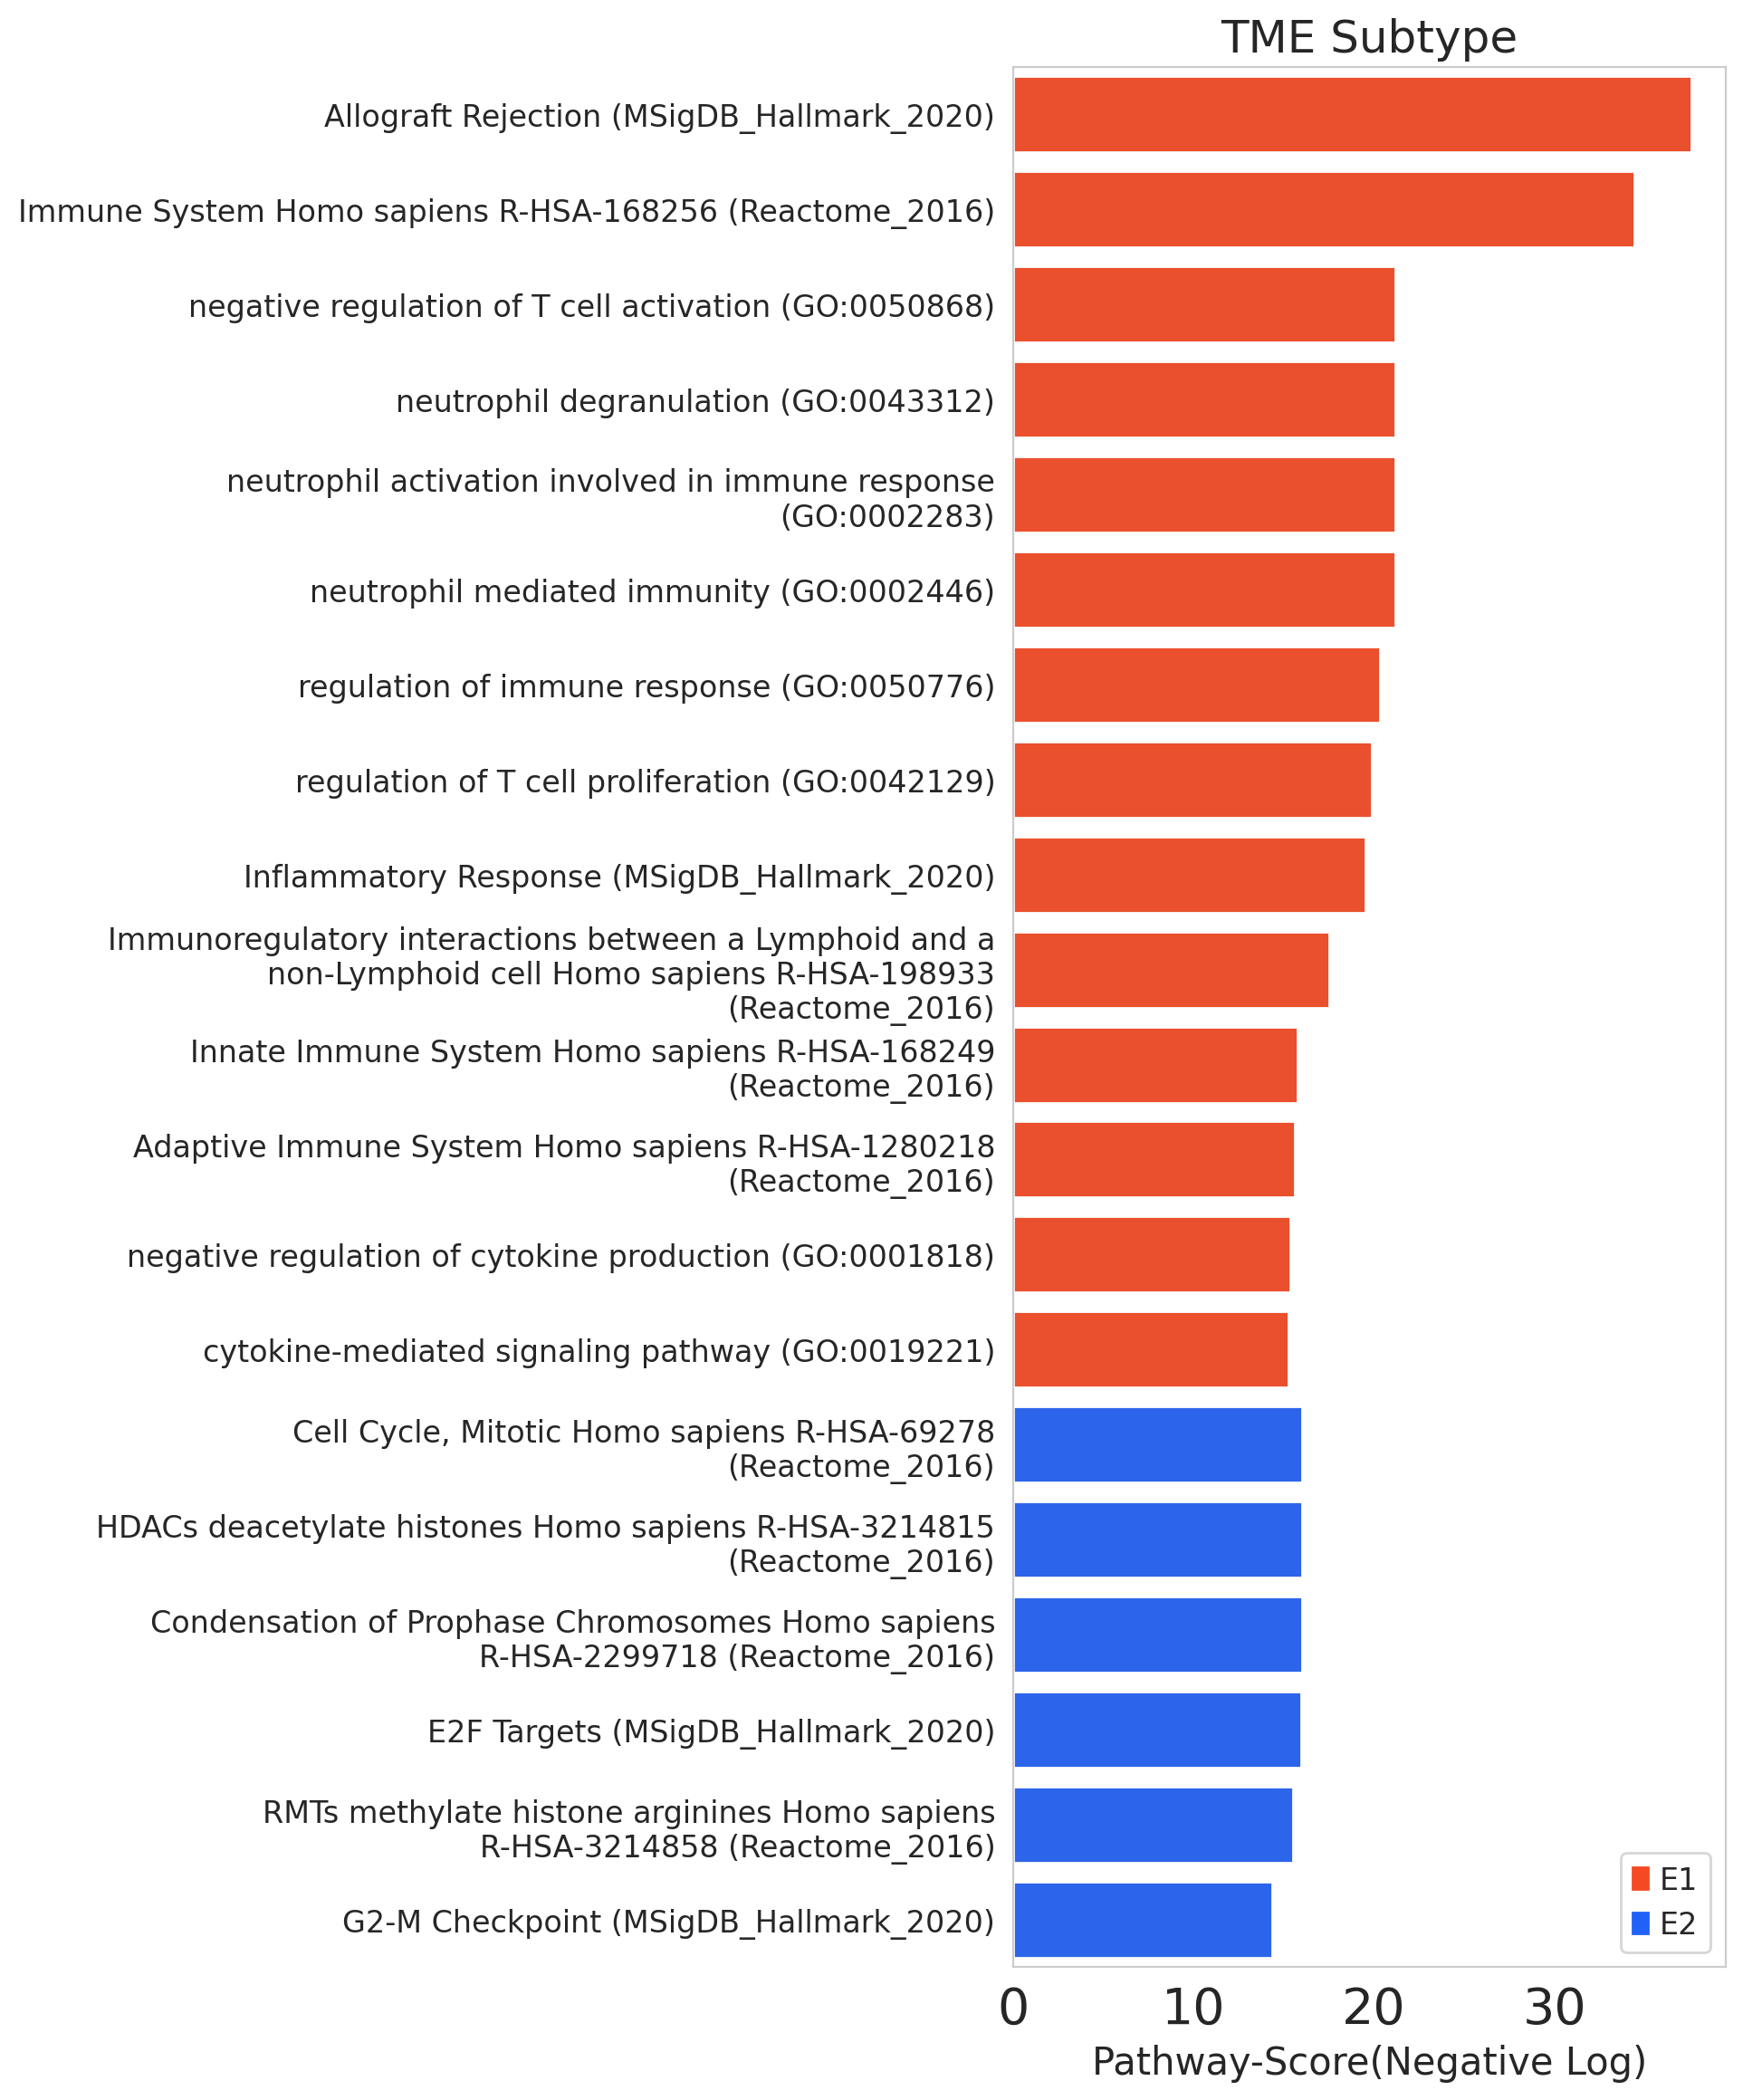

In [44]:
geneset_list = ['MSigDB_Hallmark_2020', 'KEGG_2021_Human', 'GO_Biological_Process_2021', 'Reactome_2016']
#geneset_list = ['KEGG_2021_Human', 'GO_Biological_Process_2021', 'Reactome_2016']

gsea_res_up = GSEA_custom(gene_list=up_genes,dataset_list=geneset_list)
file_dir = os.path.join(save_folder,'GSEA_{}_up.csv'.format(dkey))
gsea_res_up.to_csv(file_dir)

gsea_res_down = GSEA_custom(gene_list=down_genes,dataset_list=geneset_list)
#gsea_res_down = gsea_res_down.iloc[:3,:]
file_dir = os.path.join(save_folder,'GSEA_{}_down.csv'.format(dkey))
gsea_res_down.to_csv(file_dir)

up_df = pd.read_csv(save_folder+'/GSEA_{}_up.csv'.format(dkey),index_col=0)
up_df['Type'] = "Up-regulated"
down_df = pd.read_csv(save_folder+'/GSEA_{}_down.csv'.format(dkey),index_col=0)
down_df['Type'] = "Down-regulated"
df2plot = up_df.append(down_df)
df_sel = PS_plot(df=df2plot, test=test, control=control, ytickwidth=0.6, title='{}'.format(target_group))


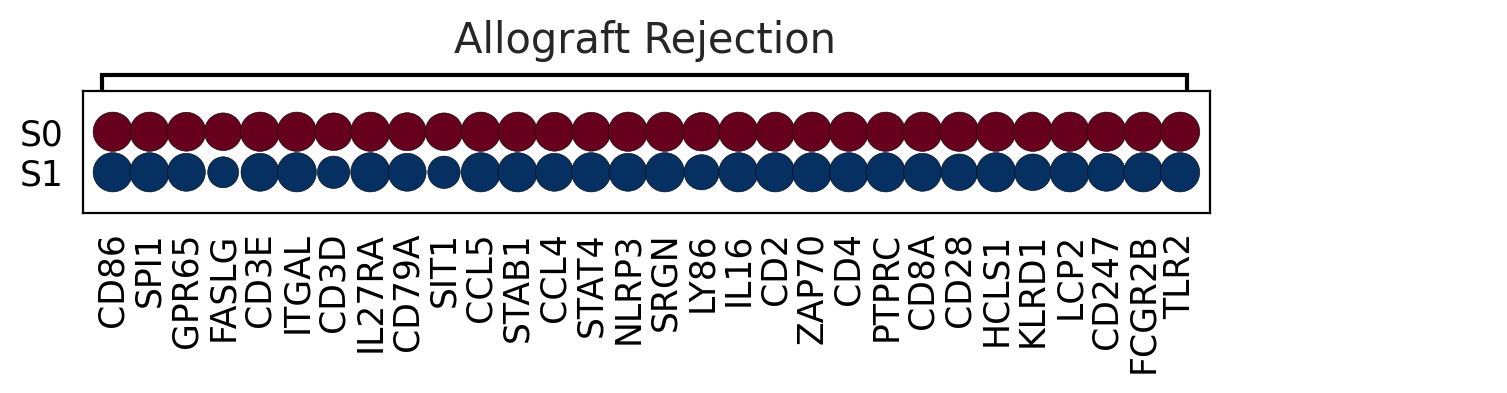

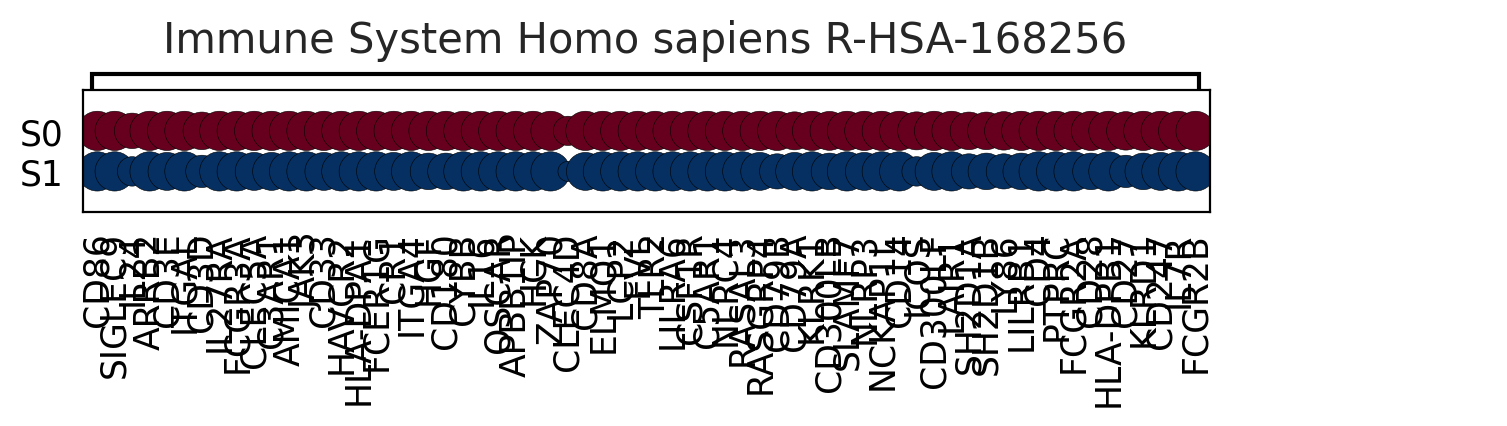

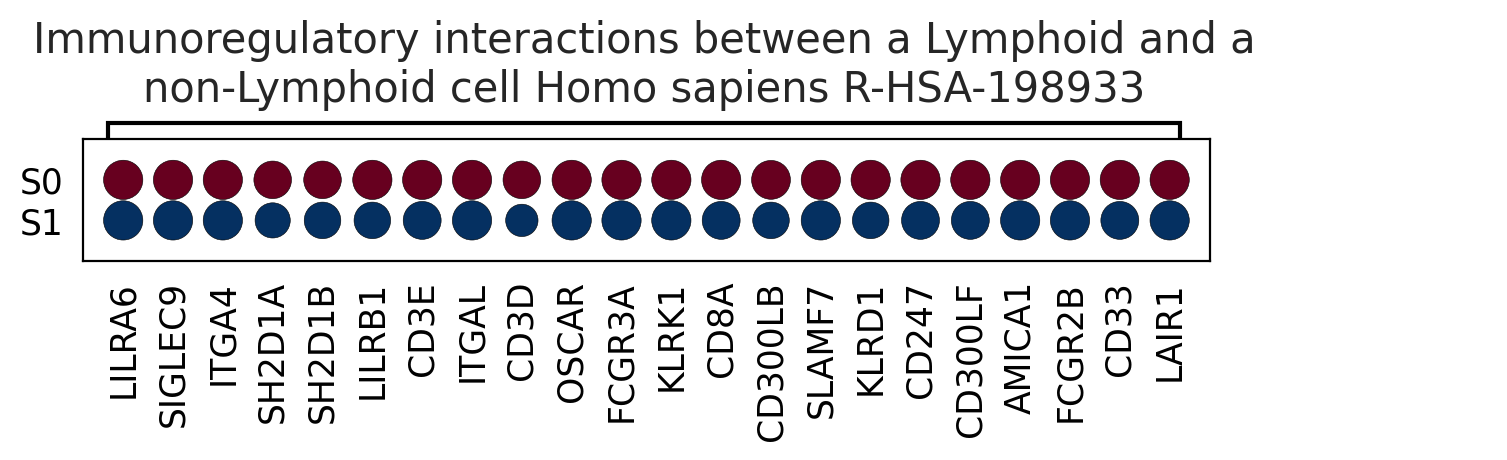

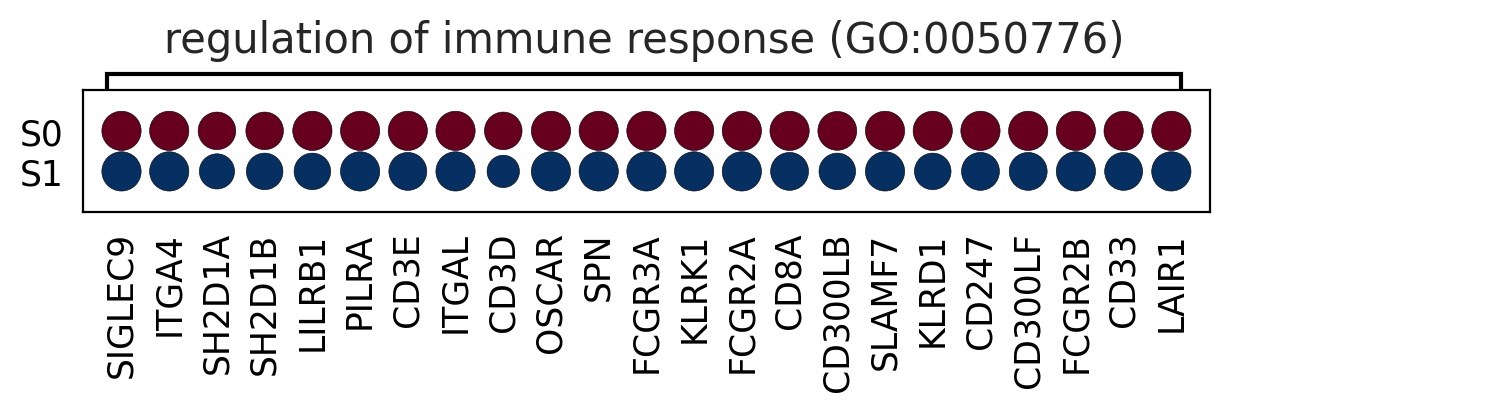

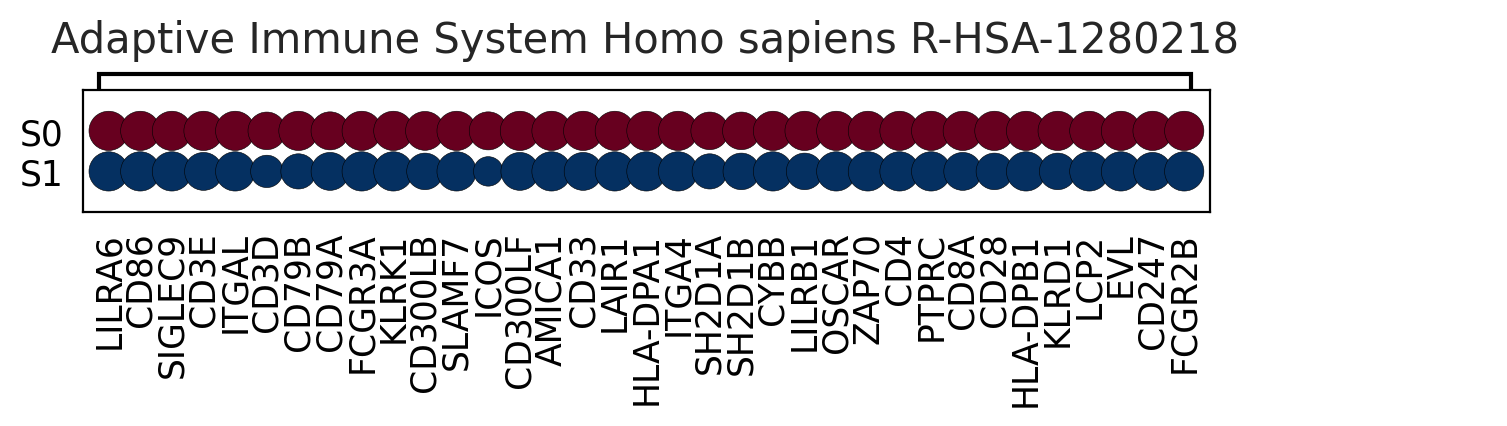

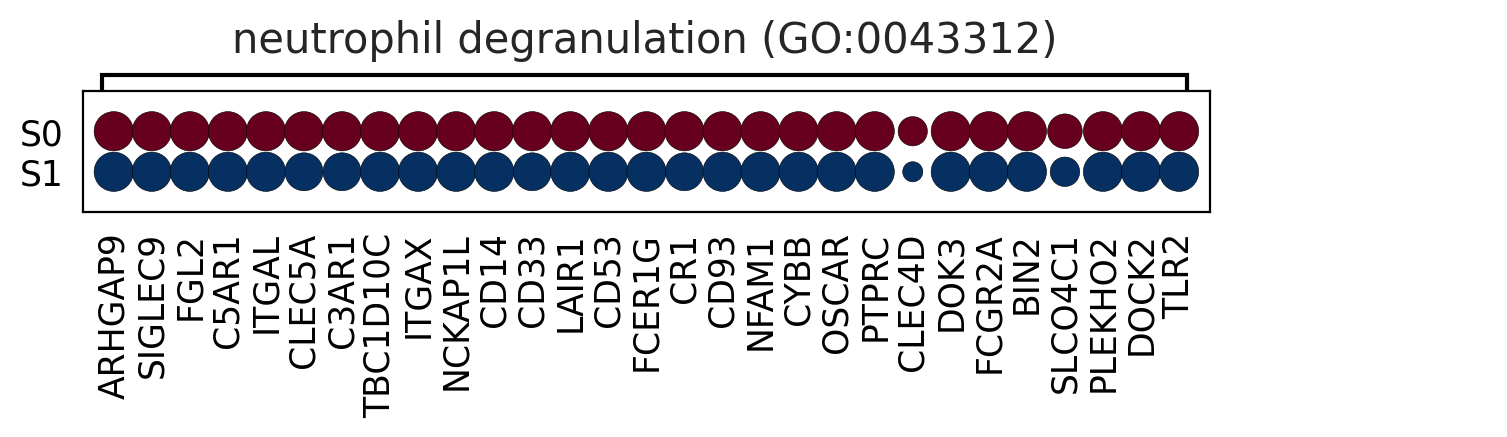

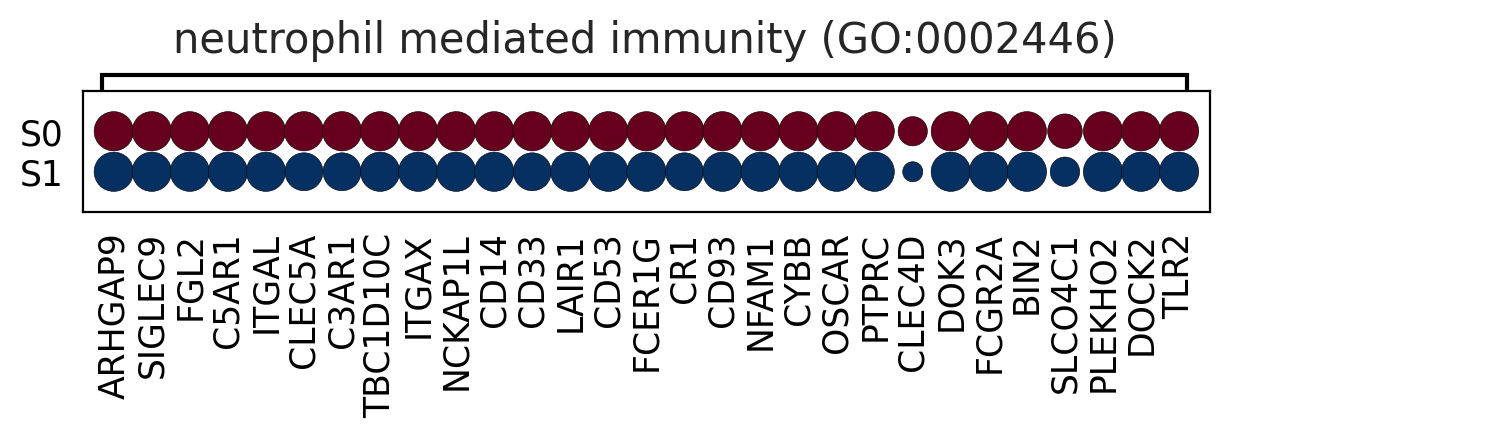

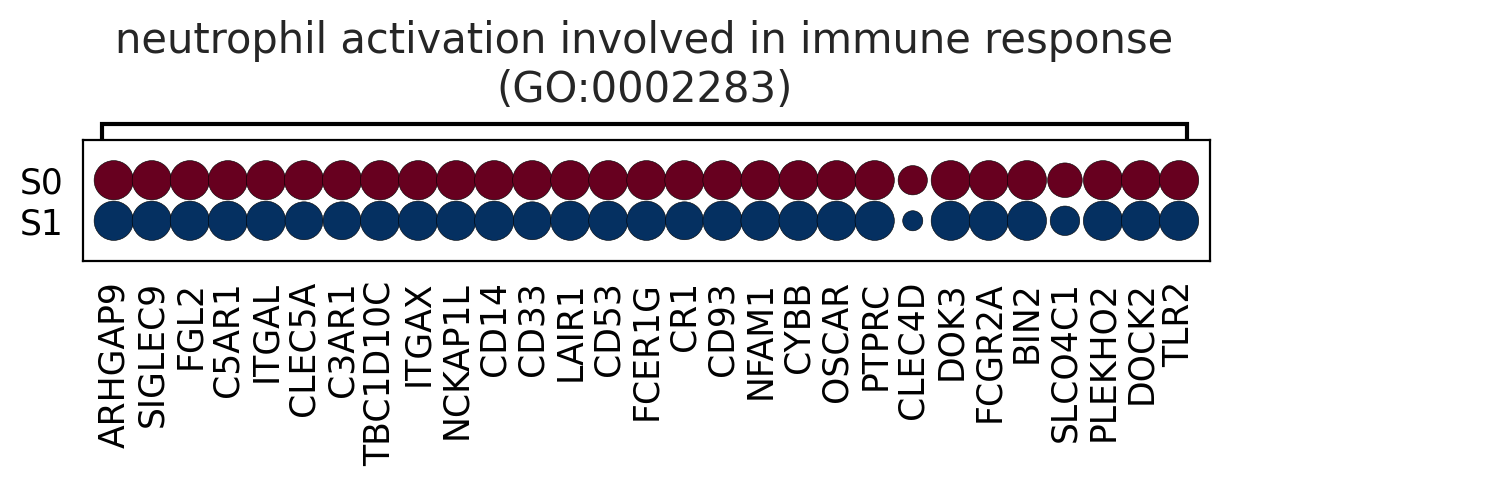

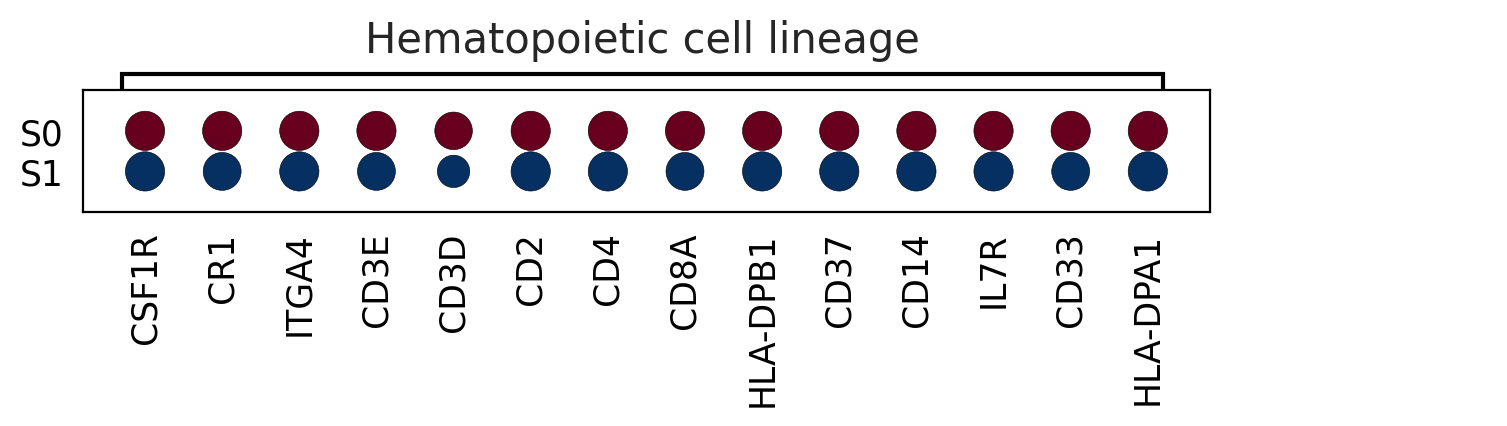

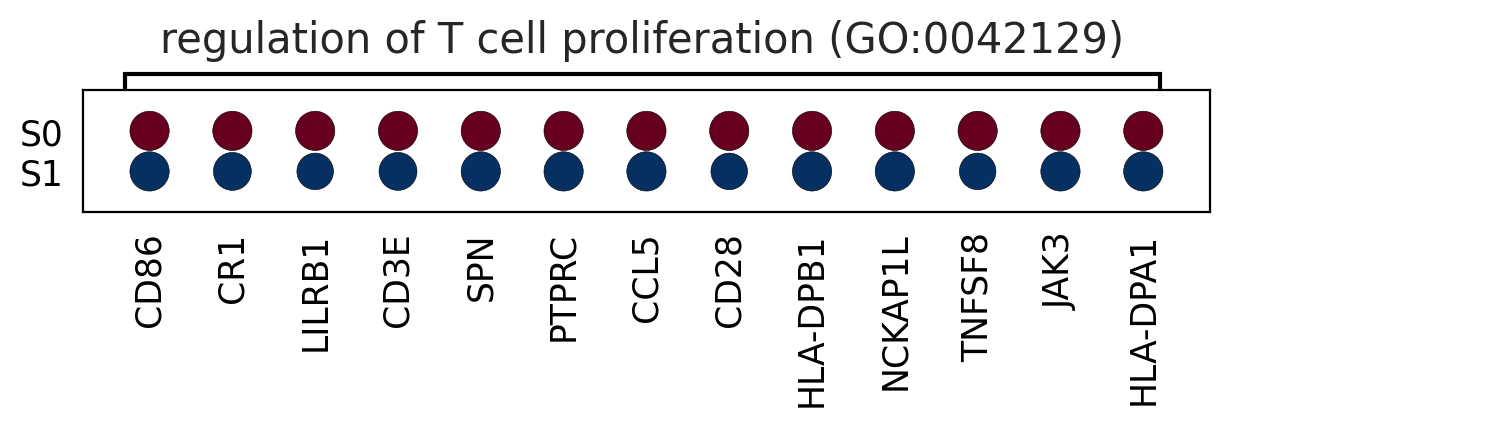

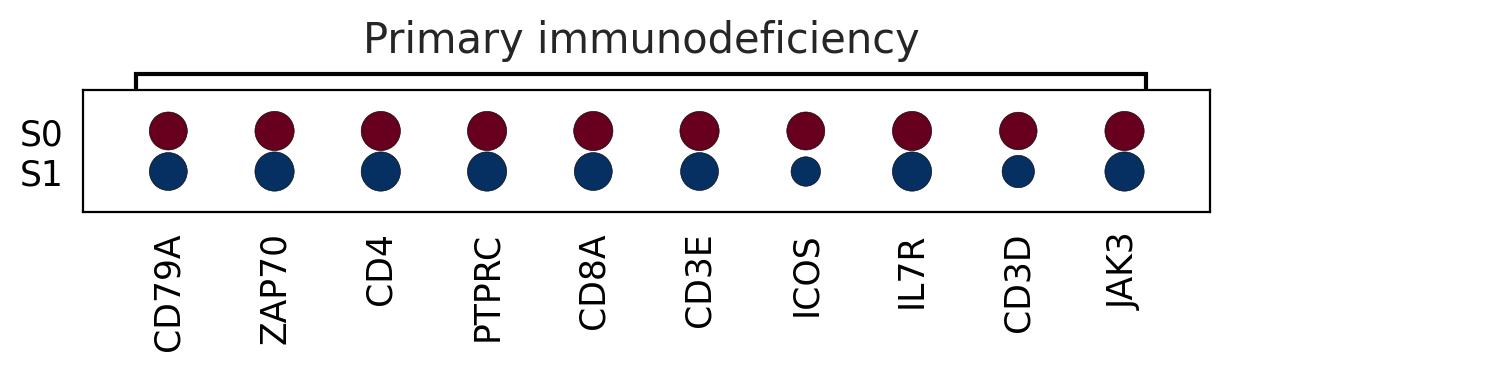

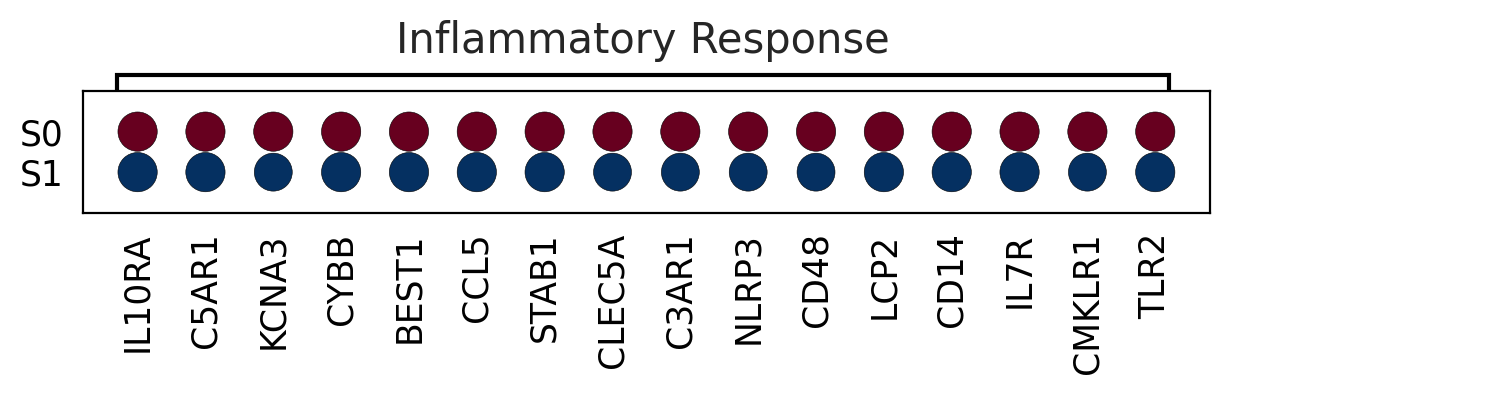

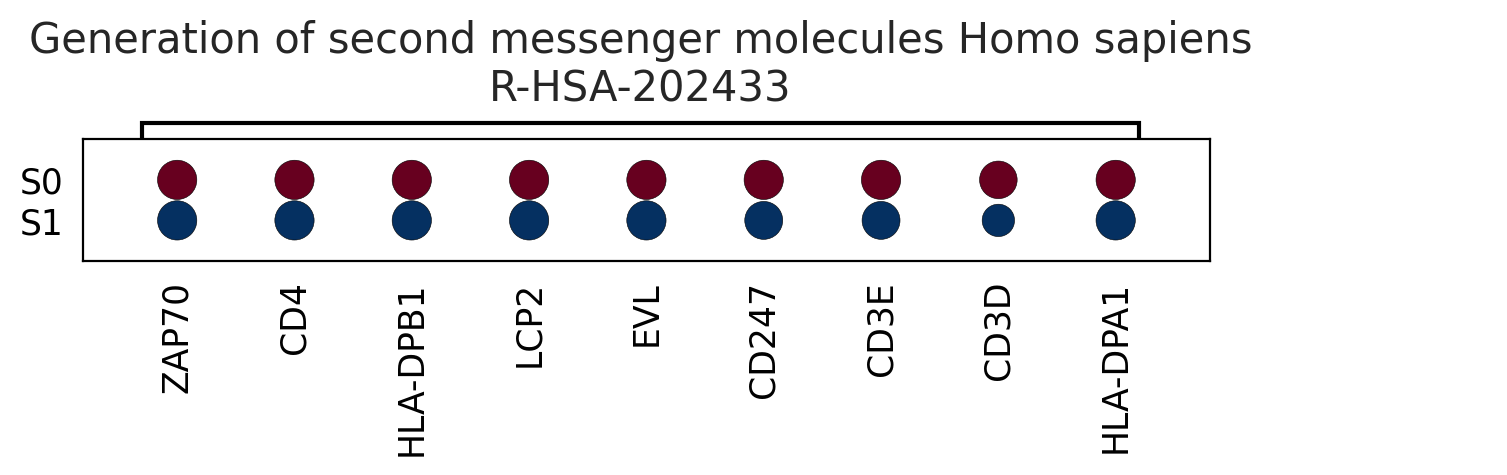

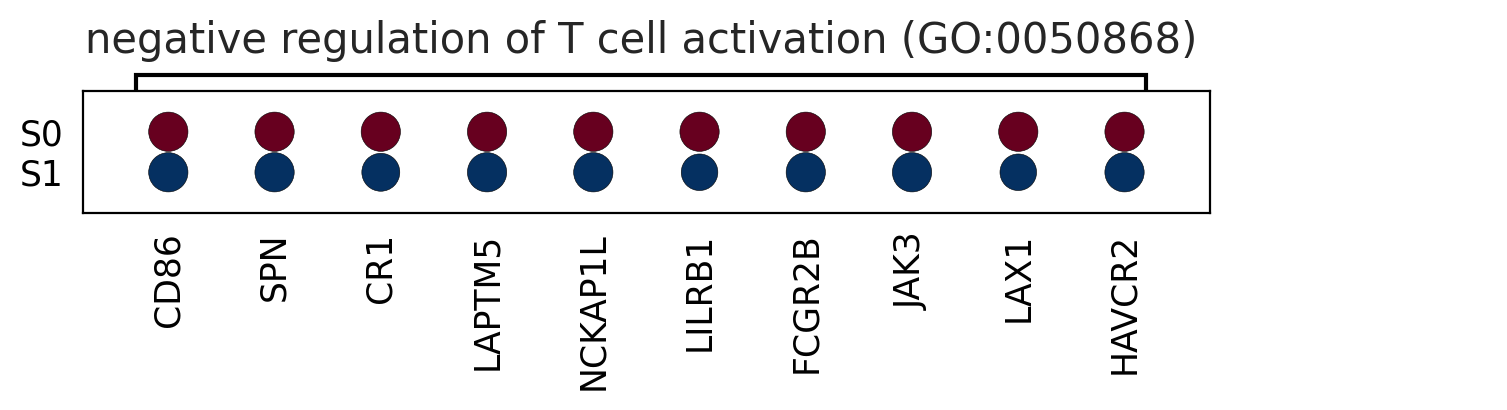

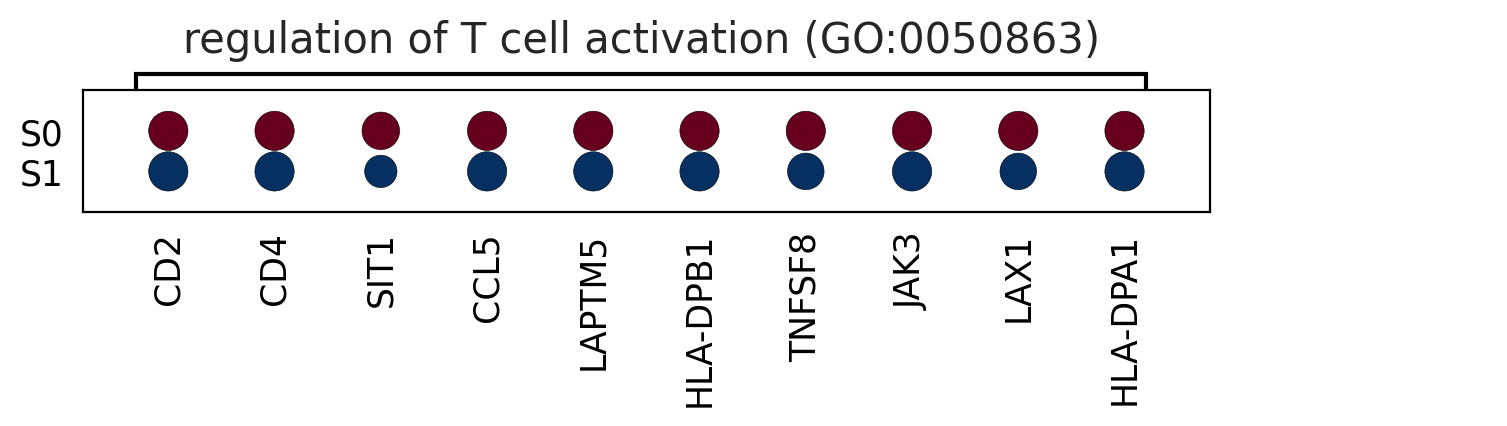

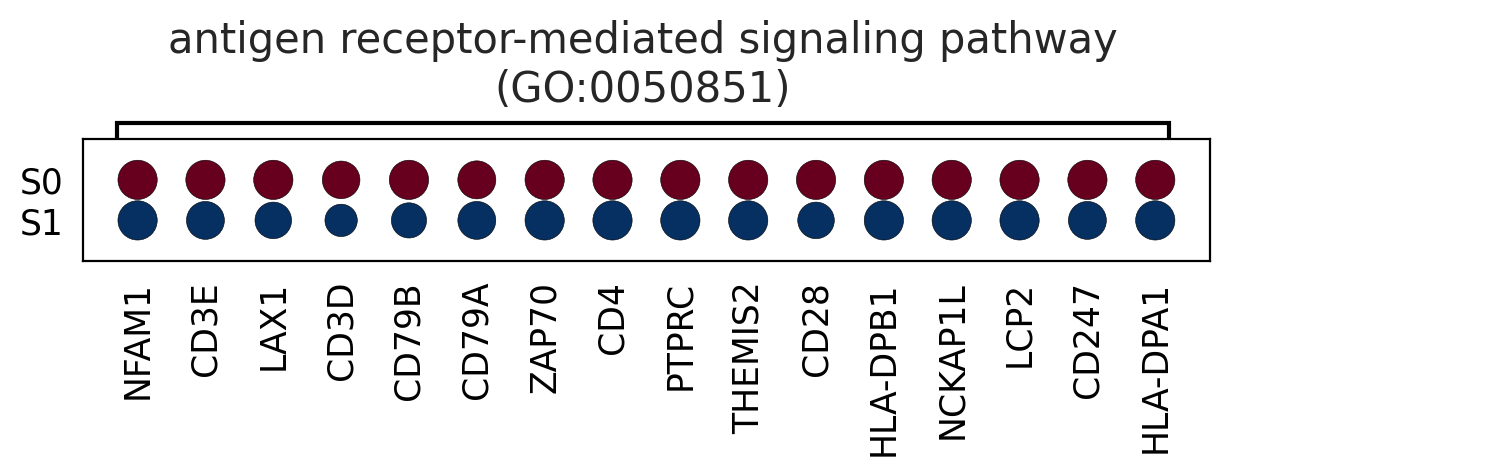

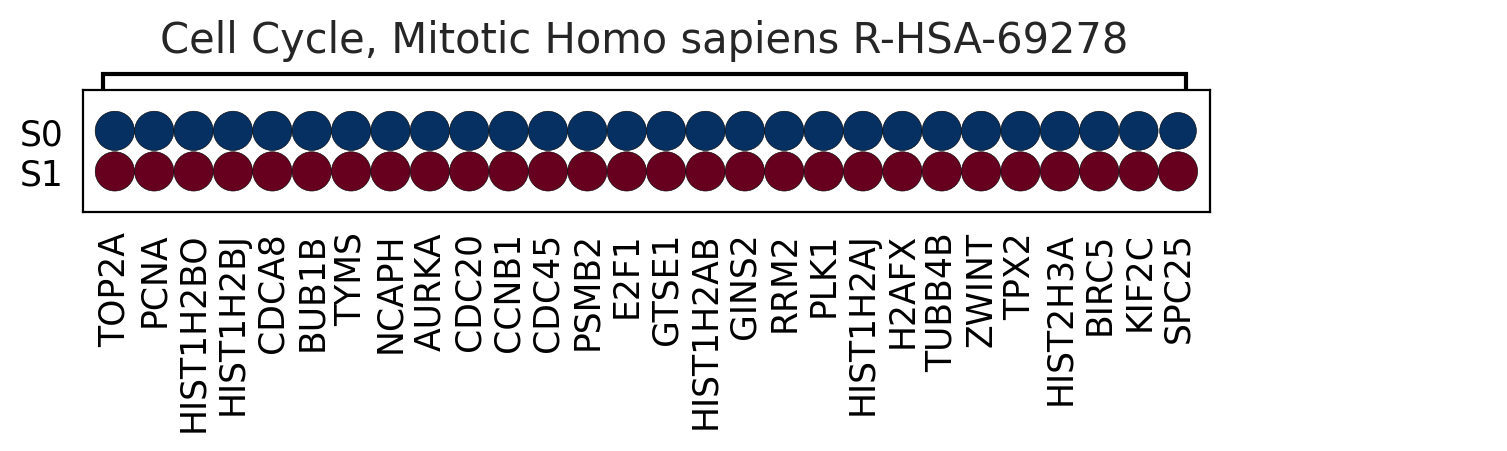

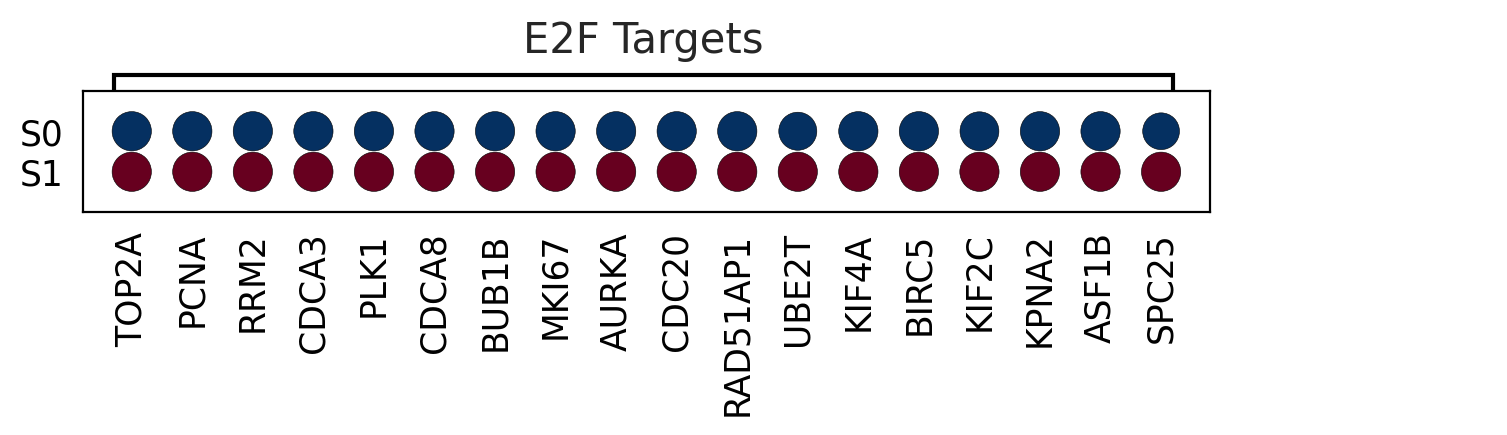

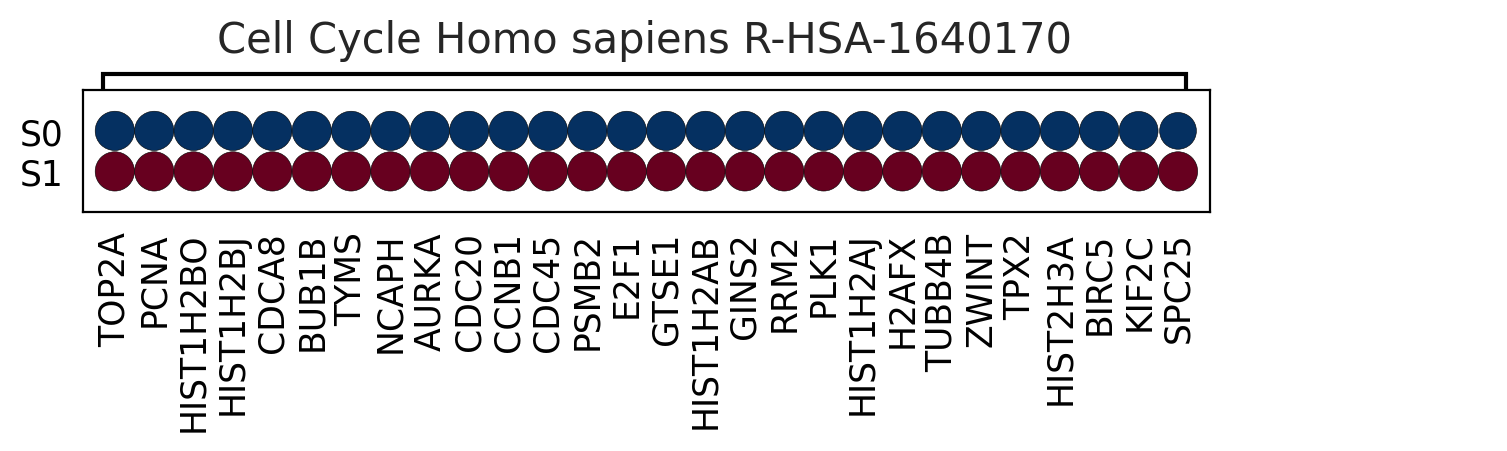

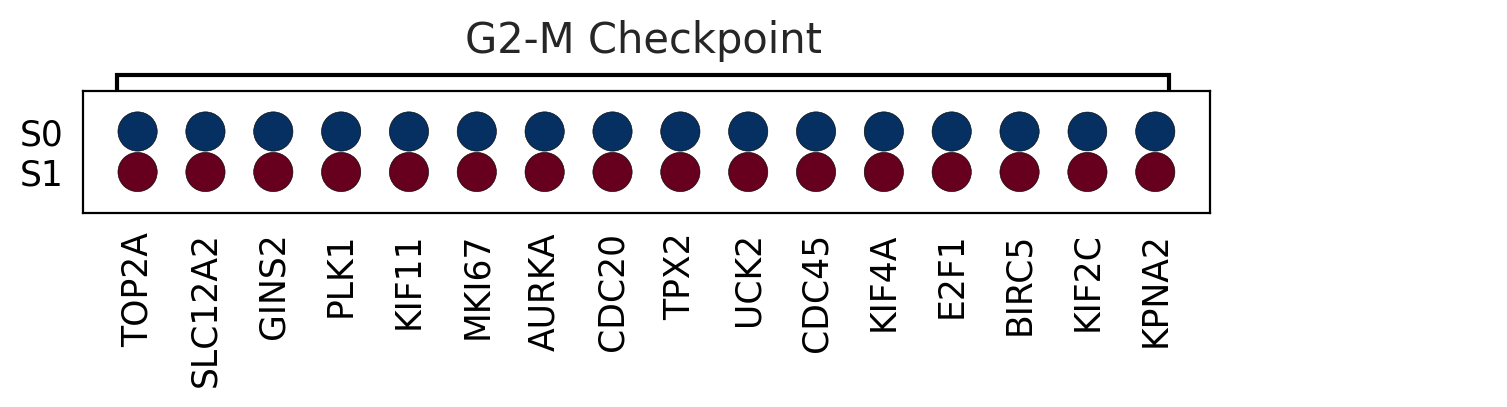

In [398]:
m = ~SNU_adata.obs[target_group].isna()
SNU_adata_sel = SNU_adata[m]

Terms = list(df_sel['Term'])
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(5, 5), facecolor='white', fontsize=15)
matplotlib.rcParams['patch.edgecolor'] = 'black'

pathway_geneset_dict = dict()
for term in Terms:
    m = df_sel['Term'] == term
    geneset = [gene for gene in df_sel.loc[m,'Genes'].values.item().split(';')]
    title = textwrap.fill(term, 55)
    ax = sc.pl.dotplot(SNU_adata, {title:geneset}, target_group,
                    dendrogram=False, var_group_rotation=0, figsize=(9,0.8), standard_scale='var', swap_axes=False,
                  vmin=0, vmax=1, return_fig=True).style(cmap='RdBu_r')
    axes_dict = ax.get_axes()
    axes_dict['size_legend_ax'].set_visible(False)
    axes_dict['color_legend_ax'].set_visible(False)
    plt.show()




# ################################################################

In [3]:
import gseapy as gp

In [4]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm.h5ad')
sc.pp.log1p(SNU_adata)

In [12]:
['Tumor Subtype','TME Subtype', 'CTx_response_FFX']

target_group = 'TME Subtype'

test = SNU_adata.obs[target_group].cat.categories[0]
print('test: {}'.format(test))
control = SNU_adata.obs[target_group].cat.categories[1]
print('control: {}'.format(control))

test_method = 't-test' # wilcoxon / t-test
groups = [test, control]
sc.tl.rank_genes_groups(SNU_adata, target_group, groups=[test], reference=control, method=test_method)

result = SNU_adata.uns['rank_genes_groups']
df_deg = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_deg[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_deg = df_deg.sort_values(by='pvals')
m = df_deg['pvals'] < 0.05
df_deg = df_deg[m]
sv_file = os.path.join(res_save_folder,'DEG_{}_{}.csv'.format(target_group,test_method))
df_deg.to_csv(sv_file)
print('{}'.format(sum(df_deg['pvals_adj']<0.05)))
m = df_deg['pvals_adj'] < 0.05
df_deg = df_deg[m]
degs = list(df_deg.index)
df_deg


test: E1
control: E2
1822


logfoldchanges         pvals     pvals_adj     scores
MS4A14           2.352552  4.246947e-19  8.488373e-15  11.464903
NCKAP1L          1.838622  2.674053e-16  2.672315e-12  11.626183
MYO1G            1.736668  1.574306e-14  1.048855e-10  10.133415
MS4A6A           1.682815  3.639553e-13  1.818594e-09   9.532481
RASAL3           1.655138  1.920640e-12  6.688772e-09   8.524631
...                   ...           ...           ...        ...
HIST1H2BN       -0.558589  4.529501e-03  4.979711e-02  -3.011096
PDE8B            0.569165  4.534817e-03  4.982814e-02   2.989965
NOTCH1           0.550638  4.545744e-03  4.992077e-02   3.024603
TIAM1            0.990427  4.549234e-03  4.992384e-02   3.091838
FAM174B         -0.726185  4.551020e-03  4.992384e-02  -2.986309

[1822 rows x 4 columns]

In [13]:
gene_exp = SNU_adata.to_df().loc[:,degs].T
gene_exp = gene_exp.reset_index()
cols = list(gene_exp.columns)
cols[0] = 'Gene'
gene_exp.columns = cols
gene_exp
# gene_exp

Gene  20-T00330_FO-01  19-T00062_FO-01  20-T00814_FT-01  \
0        MS4A14         0.688135         1.071584         1.050822   
1       NCKAP1L         2.959587         2.928524         2.134166   
2         MYO1G         3.139833         2.601207         2.080691   
3        MS4A6A         3.727379         3.004692         3.090588   
4        RASAL3         2.544747         1.585145         1.853168   
...         ...              ...              ...              ...   
1817  HIST1H2BN         3.495901         2.687847         4.199455   
1818      PDE8B         0.788457         0.824175         0.488580   
1819     NOTCH1         2.919391         2.630449         3.135494   
1820      TIAM1         3.145014         2.117460         2.073172   
1821    FAM174B         2.971952         2.840831         2.071913   

      19-T00201_FO-01  19-T00505_FO-01  20-T00764_FT-01  20-T00577_FT-01  \
0            0.756122         1.355835         0.625938         0.542324   
1            1.695616         2.817801         2.262804         2.455306   
2            1.684545         2.636912         1.662030         1.495149   
3            2.225704         3.141995         3.368330         3.136364   
4            1.427916         2.380472         1.131402         1.736951   
...               ...              ...              ...              ...   
1817         4.932890         4.175464         3.740285         4.022491   
1818         1.238374         0.625938         0.854415         0.292670   
1819         3.153590         2.805177         2.142416         2.847812   
1820         2.678278         2.406044         1.036737         1.560248   
1821         3.459466         3.266522         3.723522         3.073156   

      21-T00687_FT-01  21-T00771_FT-01  ...  19-T00380_FO-01  19-T00573_FO-01  \
0            2.683758         1.702928  ...         0.779325         0.900161   
1            4.121149         3.679334  ...         2.904713         3.088767   
2            3.407511         3.407511  ...         2.783776         2.136530   
3            4.516558         3.376905  ...         3.190888         3.063858   
4            3.020425         3.627270  ...         2.001480         2.099244   
...               ...              ...  ...              ...              ...   
1817         3.881564         3.444576  ...         3.037354         4.466483   
1818         1.071584         0.470004  ...         0.254642         0.810930   
1819         4.041471         3.547316  ...         2.306577         4.718856   
1820         3.155723         2.372111  ...         1.972691         0.850151   
1821         3.260018         2.771964  ...         2.107786         2.673459   

      20-T00105_FO-01  21-T00511_FT-01  22-T00038_FT-01  21-T00576_FT-01  \
0            0.708036         1.965713         0.841567         1.733424   
1            2.174752         3.233567         2.342767         3.295837   
2            1.845300         3.188004         2.060513         3.504055   
3            2.000128         3.315639         2.583997         3.754667   
4            1.247032         2.079442         1.576915         3.346741   
...               ...              ...              ...              ...   
1817         3.611188         4.068856         4.600057         3.334701   
1818         0.693147         0.657520         0.722706         1.054312   
1819         2.261763         2.884801         3.109953         2.674838   
1820         1.609438         2.444952         3.119718         3.139833   
1821         4.117573         2.892037         3.669697         1.880991   

      19-T00620_FO-01  19-T00413_FO-01  20-T00073_FO-01  19-T00119_FO-01  
0            2.236445         0.746688         1.800058         0.678034  
1            3.384729         1.978239         4.554508         2.768832  
2            2.759377         1.974081         4.136765         1.974081  
3            4.655673         2.020222         2.894253         3.18965

In [14]:
target_group

'TME Subtype'

In [15]:
geneset_list = ['MSigDB_Hallmark_2020', 'KEGG_2021_Human', 'GO_Biological_Process_2021', 'Reactome_2016']

if target_group == 'Tumor Subtype':
    name = 'TumorType'
elif target_group == 'TME Subtype':
    name = 'TMEType'

for geneset in geneset_list:
    print(geneset)
    ss = gp.ssgsea(data=gene_exp, gene_sets=geneset, sample_norm_method='rank', 
               no_plot=True, processes=8,)
    ss.res2d.to_csv('{}-{}-ssGSEA.csv'.format(geneset,name))
    

MSigDB_Hallmark_2020
KEGG_2021_Human
GO_Biological_Process_2021
Reactome_2016


In [16]:
files_tumor = ['MSigDB_Hallmark_2020-TumorType-ssGSEA.csv',
         'KEGG_2021_Human-TumorType-ssGSEA.csv',
         'GO_Biological_Process_2021-TumorType-ssGSEA.csv',
         'Reactome_2016-TumorType-ssGSEA.csv',
        ]
files_tme = ['MSigDB_Hallmark_2020-TMEType-ssGSEA.csv',
         'KEGG_2021_Human-TMEType-ssGSEA.csv',
         'GO_Biological_Process_2021-TMEType-ssGSEA.csv',
         'Reactome_2016-TMEType-ssGSEA.csv',
        ]

tumor_df = []
for file in files_tumor:
    df_ = pd.read_csv(file,index_col=0)
    tumor_df.append(df_)
tumor_score=pd.concat(tumor_df,axis=0).T
tumor_score

tme_df = []
for file in files_tme:
    df_ = pd.read_csv(file,index_col=0)
    tme_df.append(df_)
tme_score=pd.concat(tme_df,axis=0).T
tme_score

Term|NES         Adipogenesis  Allograft Rejection  Apical Junction  \
20-T00330_FO-01      0.369403             0.140174         0.289093   
19-T00062_FO-01      0.409912             0.176426         0.300308   
20-T00814_FT-01      0.437012             0.035093         0.253469   
19-T00201_FO-01      0.440282            -0.042611         0.247351   
19-T00505_FO-01      0.414356             0.052119         0.239075   
...                       ...                  ...              ...   
21-T00576_FT-01      0.369887             0.186262         0.225049   
19-T00620_FO-01      0.382639             0.099560         0.252233   
19-T00413_FO-01      0.421814            -0.017136         0.214112   
20-T00073_FO-01      0.203495             0.253089         0.246484   
19-T00119_FO-01      0.406187             0.028457         0.219428   

Term|NES         Apoptosis  Coagulation  Complement  E2F Targets  \
20-T00330_FO-01   0.255653     0.283206    0.265048    -0.077623   
19-T00062_FO-01   0.306098     0.321055    0.276646    -0.079781   
20-T00814_FT-01   0.249935     0.253800    0.190262     0.169559   
19-T00201_FO-01   0.235557     0.214171    0.109948     0.342440   
19-T00505_FO-01   0.236713     0.250223    0.221543     0.078950   
...                    ...          ...         ...          ...   
21-T00576_FT-01   0.285390     0.330963    0.285495    -0.088676   
19-T00620_FO-01   0.171793     0.322198    0.253512     0.285249   
19-T00413_FO-01   0.190521     0.161265    0.114628     0.224431   
20-T00073_FO-01   0.209265     0.091921    0.235466    -0.024926   
19-T00119_FO-01   0.175956     0.207880    0.117649     0.194104   

Term|NES         Epithelial Mesenchymal Transition  Estrogen Response Early  \
20-T00330_FO-01                           0.200988                 0.295694   
19-T00062_FO-01                           0.404934                 0.312021   
20-T00814_FT-01                           0.226196                 0.292773   
19-T00201_FO-01                           0.187377                 0.382326   
19-T00505_FO-01                           0.170925                 0.367936   
...                                            ...                      ...   
21-T00576_FT-01                           0.189226                 0.321962   
19-T00620_FO-01                           0.176165                 0.335315   
19-T00413_FO-01                           0.090462                 0.339374   
20-T00073_FO-01                           0.183250                 0.192861   
19-T00119_FO-01                           0.081672                 0.334822   

Term|NES         Estrogen Response Late  ...  \
20-T00330_FO-01                0.285116  ...   
19-T00062_FO-01                0.291724  ...   
20-T00814_FT-01                0.317509  ...   
19-T00201_FO-01                0.394049  ...   
19-T00505_FO-01                0.354637  ...   
...                                 ...  ...   
21-T00576_FT-01                0.310660  ...   
19-T00620_FO-01                0.327750  ...   
19-T00413_FO-01                0.354202  ...   
20-T00073_FO-01                0.191282  ...   
19-T00119_FO-01                0.369132  ...   

Term|NES         TCR signaling Homo sapiens R-HSA-202403  \
20-T00330_FO-01                                 0.301615   
19-T00062_FO-01                                 0.337574   
20-T00814_FT-01                                 0.238150   
19-T00201_FO-01                                 0.120702   
19-T00505_FO-01                                 0.267191   
...                                                  ...   
21-T00576_FT-01                                 0.321108   
19-T00620_FO-01                                 0.246984   
19-T00413_FO-01                                 0.155606   
20-T00073_FO-01                                 0.367230   
19-T00119_FO-01                                 0.158351   

Term|NES         TNFR2 non-canonical NF-kB pathway Homo sapiens R-HSA-5668541  \
20

In [17]:
tumor_score.to_csv('Tumor_NES.csv')
tme_score.to_csv('TME_NES.csv')

In [18]:
tumor_score

Term|NES         Adipogenesis  Allograft Rejection  Androgen Response  \
20-T00330_FO-01      0.381171             0.087989           0.252906   
19-T00062_FO-01      0.353928             0.127449           0.361286   
20-T00814_FT-01      0.327881            -0.081755           0.287974   
19-T00201_FO-01      0.383757            -0.179651           0.341376   
19-T00505_FO-01      0.337671            -0.074875           0.391800   
...                       ...                  ...                ...   
21-T00576_FT-01      0.329786             0.156072           0.425368   
19-T00620_FO-01      0.348460             0.025610           0.414404   
19-T00413_FO-01      0.355015            -0.199528           0.340001   
20-T00073_FO-01      0.271113             0.286804           0.239622   
19-T00119_FO-01      0.373116            -0.039948           0.377201   

Term|NES         Apical Junction  Apical Surface  Apoptosis  \
20-T00330_FO-01         0.432239        0.131987   0.478031   
19-T00062_FO-01         0.435106        0.088481   0.451668   
20-T00814_FT-01         0.433319        0.044381   0.399222   
19-T00201_FO-01         0.387783        0.054670   0.419117   
19-T00505_FO-01         0.436359        0.029215   0.400467   
...                          ...             ...        ...   
21-T00576_FT-01         0.446499        0.061336   0.437996   
19-T00620_FO-01         0.379529        0.117510   0.398391   
19-T00413_FO-01         0.422475        0.024078   0.373178   
20-T00073_FO-01         0.358023        0.080569   0.369774   
19-T00119_FO-01         0.388739       -0.034349   0.335484   

Term|NES         Bile Acid Metabolism  Cholesterol Homeostasis  Coagulation  \
20-T00330_FO-01              0.010759                 0.191839     0.212978   
19-T00062_FO-01              0.037407                 0.277123     0.259436   
20-T00814_FT-01              0.056467                 0.203708     0.228766   
19-T00201_FO-01              0.043546                 0.190497     0.164582   
19-T00505_FO-01              0.063956                 0.349499     0.238100   
...                               ...                      ...          ...   
21-T00576_FT-01              0.069235                 0.395095     0.287664   
19-T00620_FO-01              0.030225                 0.434067     0.218182   
19-T00413_FO-01              0.115608                 0.246855     0.250013   
20-T00073_FO-01             -0.022769                 0.133847     0.037781   
19-T00119_FO-01              0.097656                 0.270584     0.242241   

Term|NES         Complement  ...  mTOR signalling Homo sapiens R-HSA-165159  \
20-T00330_FO-01    0.201118  ...                                   0.282155   
19-T00062_FO-01    0.253509  ...                                   0.308586   
20-T00814_FT-01    0.212467  ...                                   0.274237   
19-T00201_FO-01    0.096017  ...                                   0.275824   
19-T00505_FO-01    0.188145  ...                                   0.269999   
...                     ...  ...                                        ...   
21-T00576_FT-01    0.316189  ...                                   0.311630   
19-T00620_FO-01    0.181817  ...                                   0.343240   
19-T00413_FO-01    0.136857  ...                                   0.254930   
20-T00073_FO-01    0.246018  ...                                   0.223595   
19-T00119_FO-01    0.163946  ...                                   0.264208   

Term|NES         p53-Dependent G1 DNA Damage Response Homo sapiens R-HSA-69563  \
20-T00330_FO-01                                           0.396442               
19-T00062_FO-01                                           0.357585               
20-T00814_FT-01                                           0.389737               
19-T00201_FO-01                                           0.402984               
19-T00505_FO-01                                           

In [19]:
SNU_adata.obs

N0       PID       dateA         Snubh_BB  \
Snubh_TB                                                         
20-T00330_FO-01  sb2441  32644755  2020-05-15  20-B01156_EB-03   
19-T00062_FO-01  sb1947  10108754  2019-03-18  19-B00635_EB-03   
20-T00814_FT-01  sb2669  33563897  2020-12-16  20-B04522_EB-04   
19-T00201_FO-01  sb2097  24118798  2019-05-27              NaN   
19-T00505_FO-01  sb2298  31651231  2019-09-09  19-B02081_EB-03   
...                 ...       ...         ...              ...   
21-T00576_FT-01     NaN  10805327  2021-07-23              NaN   
19-T00620_FO-01  sb2342  31927356  2019-10-30  19-B02516_EB-03   
19-T00413_FO-01  sb2283  31464792  2019-08-06  19-B01826_EB-03   
20-T00073_FO-01  sb1988  11769796  2020-02-03  20-B00280_EB-03   
19-T00119_FO-01  sb2223  30981162  2019-04-30              NaN   

                pathology_number tumorcellularity(pathology)  DNA_RNA  \
Snubh_TB                                                                
20-T00330_FO-01      S 200019390                          25  DNA+RNA   
19-T00062_FO-01      S 190013089                          45  DNA+RNA   
20-T00814_FT-01      S 200053444                          35  DNA+RNA   
19-T00201_FO-01      S 190025387                          40      RNA   
19-T00505_FO-01      S 190043830                          50  DNA+RNA   
...                          ...                         ...      ...   
21-T00576_FT-01      S 210032997                         NaN      RNA   
19-T00620_FO-01      S 190052008                          35  DNA+RNA   
19-T00413_FO-01      S 190038136                          20  DNA+RNA   
20-T00073_FO-01      S 200005133                          45  DNA+RNA   
19-T00119_FO-01      S 190021043                           5      RNA   

                 methylSeq  metagenomic liquid_number  ...  OS_F stage_2  \
Snubh_TB                                               ...                 
20-T00330_FO-01        NaN          NaN          R167  ...  26.7     NaN   
19-T00062_FO-01        NaN          NaN           NaN  ...   7.2     NaN   
20-T00814_FT-01        NaN          NaN          R201  ...   8.3     NaN   
19-T00201_FO-01        NaN          NaN          R017  ...  25.9     NaN   
19-T00505_FO-01        NaN          NaN          R074  ...  34.4     NaN   
...                    ...          ...           ...  ...   ...     ...   
21-T00576_FT-01        NaN          NaN           NaN  ...   5.1     NaN   
19-T00620_FO-01        NaN          NaN          R106  ...   2.2     NaN   
19-T00413_FO-01        NaN          NaN           NaN  ...  36.2     NaN   
20-T00073_FO-01        NaN          NaN           NaN  ...  15.6     NaN   
19-T00119_FO-01        NaN          NaN           NaN  ...  17.2     NaN   

                 Tumor Subtype TME Subtype  Moffitt Subtype  \
Snubh_TB                                                      
20-T00330_FO-01             C2          E1        BasalLike   
19-T00062_FO-01             C2          E1        BasalLike   
20-T00814_FT-01             C1          E1        BasalLike   
19-T00201_FO-01             C2          E2        BasalLike   
19-T00505_FO-01             C1          E1        Classical   
...                        ...         ...              ...   
21-T00576_FT-01             C1          E1        Classical   
19-T00620_FO-01             C2          E1        BasalLike   
19-T00413_FO-01             C1          E2        Classical   
20-T00073_FO-01             C2          E1        BasalLike   
19-T00119_FO-01             C1          E2        Classical   

                        Bailey Subtype  Chan-Seng-Yue Subtype  \
Snubh_TB                                                        
20-T00330_FO-01               Squamous            BasalLike-B   
19-T00062_FO-01                   ADEX            BasalLike-A   
20-T00814_FT-01  Pancreatic Progenitor            Classical-B   
19-T00201_FO-01               Squamous                 Hybrid   
19-T00505_FO-

In [20]:
tumor_adata = sc.AnnData(tumor_score)
tumor_adata.obs = SNU_adata.obs.copy()

target_group = 'Tumor Subtype'
test = tumor_adata.obs[target_group].cat.categories[0]
print('test: {}'.format(test))
control = tumor_adata.obs[target_group].cat.categories[1]
print('control: {}'.format(control))

test_method = 't-test' # wilcoxon / t-test
groups = [test, control]
sc.tl.rank_genes_groups(tumor_adata, target_group, groups=[test], reference=control, method=test_method)

result = tumor_adata.uns['rank_genes_groups']
df_tumor_score = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_tumor_score[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_tumor_score = df_tumor_score.sort_values(by='pvals_adj')
m = df_tumor_score['pvals_adj'] < 1e-5
df_tumor_score = df_tumor_score[m]
df_tumor_score.to_csv('Tumor_NES_diff.csv')
df_tumor_score

test: C1
control: C2


/tmp/ipykernel_2933380/3654797194.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tumor_adata = sc.AnnData(tumor_score)
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


logfoldchanges  \
Phase 1 - Functionalization of compounds Homo s...             NaN   
carbohydrate homeostasis (GO:0033500)                     1.160866   
MicroRNAs in cancer                                      -0.616380   
Biological oxidations Homo sapiens R-HSA-211859                NaN   
Glycerolipid metabolism                                   1.483371   
...                                                            ...   
organic acid transport (GO:0015849)                      -1.179964   
Synthesis of PIPs at the plasma membrane Homo s...       -2.225152   
Influenza Viral RNA Transcription and Replicati...       -0.063883   
Neuronal System Homo sapiens R-HSA-112316                 2.142953   
regulation of lipid metabolic process (GO:0019216)        0.441877   

                                                           pvals  \
Phase 1 - Functionalization of compounds Homo s...  2.185430e-20   
carbohydrate homeostasis (GO:0033500)               1.826666e-19   
MicroRNAs in cancer                                 2.476978e-18   
Biological oxidations Homo sapiens R-HSA-211859     1.874351e-18   
Glycerolipid metabolism                             5.200286e-18   
...                                                          ...   
organic acid transport (GO:0015849)                 2.613093e-06   
Synthesis of PIPs at the plasma membrane Homo s...  2.617708e-06   
Influenza Viral RNA Transcription and Replicati...  2.640129e-06   
Neuronal System Homo sapiens R-HSA-112316           2.670766e-06   
regulation of lipid metabolic process (GO:0019216)  2.670842e-06   

                                                       pvals_adj     scores  
Phase 1 - Functionalization of compounds Homo s...  4.451721e-17  11.970839  
carbohydrate homeostasis (GO:0033500)               1.860460e-16  11.553850  
MicroRNAs in cancer                                 1.261401e-15 -10.988156  
Biological oxidations Homo sapiens R-HSA-211859     1.261401e-15  11.026786  
Glycerolipid metabolism                             2.017554e-15  10.901340  
...                                                          ...        ...  
organic acid transport (GO:0015849)                 9.695038e-06   5.106713  
Synthesis of PIPs at the plasma membrane Homo s...  9.695038e-06  -5.108344  
Influenza Viral RNA Transcription and Replicati...  9.760331e-06  -5.092716  
Neuronal System Homo sapiens R-HSA-112316           9.838166e-06   5.015140  
regulation of lipid metabolic process (GO:0019216)  9.838166e-06   5.039244  

[553 rows x 4 columns]

In [21]:
EMT_Pos_sig = [
    'Epithelial Mesenchymal Transition'   
]

EMT_Neg_sig = [
    'Cell junction organization Homo sapiens R-HSA-446728',
    'Cell-cell junction organization Homo sapiens R-HSA-421270',
]

apoptotic_regulation = [
    'positive regulation of intrinsic apoptotic signaling pathway (GO:2001244)',
    'regulation of extrinsic apoptotic signaling pathway via death domain receptors (GO:1902041)',
    'regulation of intrinsic apoptotic signaling pathway (GO:2001242)',
    'positive regulation of apoptotic signaling pathway (GO:2001235)',
    'positive regulation of apoptotic process (GO:0043065)',
]

O_glycosylation = [
    'Mucin type O-glycan biosynthesis',
    'protein O-linked glycosylation (GO:0006493)',
    'O-linked glycosylation of mucins Homo sapiens R-HSA-913709',
    'O-glycan processing (GO:0016266)',
    'O-linked glycosylation Homo sapiens R-HSA-5173105'
]

vegf = [
    'Signaling by VEGF Homo sapiens R-HSA-194138',
    'vascular endothelial growth factor receptor signaling pathway (GO:0048010)',
    'VEGFA-VEGFR2 Pathway Homo sapiens R-HSA-4420097',
    'VEGF signaling pathway'
]

Tumor_Features = EMT_Pos_sig+EMT_Neg_sig+apoptotic_regulation+O_glycosylation+vegf
tumor_score.loc[:,Tumor_Features]
df_tumor_score.loc[EMT_Pos_sig,:].sort_values(by='scores',ascending=False)

logfoldchanges         pvals     pvals_adj  \
Epithelial Mesenchymal Transition       -0.754034  5.052847e-08  3.226536e-07   

                                     scores  
Epithelial Mesenchymal Transition -6.068413

In [191]:
df_tumor_score.index

Index(['Phase 1 - Functionalization of compounds Homo sapiens R-HSA-211945',
       'MicroRNAs in cancer', 'regulation of organelle assembly (GO:1902115)',
       'Biological oxidations Homo sapiens R-HSA-211859',
       'sodium ion transmembrane transport (GO:0035725)',
       'carbohydrate homeostasis (GO:0033500)',
       'epithelial cell differentiation (GO:0030855)', 'Amphetamine addiction',
       'positive regulation of blood vessel endothelial cell migration (GO:0043536)',
       'steroid metabolic process (GO:0008202)',
       ...
       'negative regulation of NF-kappaB transcription factor activity (GO:0032088)',
       'RHO GTPases Activate Formins Homo sapiens R-HSA-5663220',
       'regulation of intracellular pH (GO:0051453)',
       'Interleukin-1 signaling Homo sapiens R-HSA-446652',
       'organelle assembly (GO:0070925)',
       'Viral protein interaction with cytokine and cytokine receptor',
       'AMPK signaling pathway', 'Steroid biosynthesis', 'KRAS Signaling D

In [22]:
tme_adata = sc.AnnData(tme_score)
tme_adata.obs = SNU_adata.obs.copy()
target_group = 'TME Subtype'
test = tme_adata.obs[target_group].cat.categories[0]
print('test: {}'.format(test))
control = tme_adata.obs[target_group].cat.categories[1]
print('control: {}'.format(control))

test_method = 't-test' # wilcoxon / t-test
groups = [test, control]
sc.tl.rank_genes_groups(tme_adata, target_group, groups=[test], reference=control, method=test_method)

result = tme_adata.uns['rank_genes_groups']
df_tme_score = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_tme_score[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_tme_score = df_tme_score.sort_values(by='pvals_adj')
m = df_tme_score['pvals_adj'] < 1e-5
df_tme_score = df_tme_score[m]
df_tme_score.to_csv('TME_NES_diff.csv')
df_tme_score

test: E1
control: E2


/tmp/ipykernel_2933380/2287355613.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tme_adata = sc.AnnData(tme_score)
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


logfoldchanges  \
positive regulation of phagocytosis (GO:0050766)               NaN   
regulation of T cell proliferation (GO:0042129)                NaN   
negative regulation of inflammatory response to...             NaN   
negative regulation of T cell activation (GO:00...             NaN   
Yersinia infection                                        1.063221   
...                                                            ...   
Interleukin receptor SHC signaling Homo sapiens...        0.618667   
VEGFR2 mediated cell proliferation Homo sapiens...        0.866911   
positive regulation of reactive oxygen species ...        0.523146   
Coagulation                                               0.567108   
positive regulation of cell differentiation (GO...             NaN   

                                                           pvals  \
positive regulation of phagocytosis (GO:0050766)    1.903552e-17   
regulation of T cell proliferation (GO:0042129)     3.533873e-17   
negative regulation of inflammatory response to...  3.059557e-17   
negative regulation of T cell activation (GO:00...  2.221812e-17   
Yersinia infection                                  7.481840e-17   
...                                                          ...   
Interleukin receptor SHC signaling Homo sapiens...  4.635781e-06   
VEGFR2 mediated cell proliferation Homo sapiens...  5.050741e-06   
positive regulation of reactive oxygen species ...  5.335965e-06   
Coagulation                                         5.988874e-06   
positive regulation of cell differentiation (GO...  6.221230e-06   

                                                       pvals_adj     scores  
positive regulation of phagocytosis (GO:0050766)    6.104766e-15  11.776914  
regulation of T cell proliferation (GO:0042129)     6.104766e-15  11.255835  
negative regulation of inflammatory response to...  6.104766e-15  11.226737  
negative regulation of T cell activation (GO:00...  6.104766e-15  11.063168  
Yersinia infection                                  1.033990e-14  10.632965  
...                                                          ...        ...  
Interleukin receptor SHC signaling Homo sapiens...  7.397979e-06   5.228566  
VEGFR2 mediated cell proliferation Homo sapiens...  8.041618e-06   5.117015  
positive regulation of reactive oxygen species ...  8.476212e-06   5.279382  
Coagulation                                         9.491542e-06   5.249510  
positive regulation of cell differentiation (GO...  9.837231e-06   5.231515  

[437 rows x 4 columns]

In [28]:
m = df_tme_score.index.str.contains('TGF')
df_tme_score[m]

Empty DataFrame
Columns: [logfoldchanges, pvals, pvals_adj, scores]
Index: []

In [23]:
cellcycle = [
    'Mitotic G1-G1/S phases Homo sapiens R-HSA-453279',
    'G1/S Transition Homo sapiens R-HSA-69206',
    'regulation of mitotic cell cycle phase transition (GO:1901990)',
    'E2F Targets',
    'G2-M Checkpoint',
    'G2/M Checkpoints Homo sapiens R-HSA-69481'
]

platelet = [
    'Platelet activation',
    'Platelet activation, signaling and aggregation Homo sapiens R-HSA-76002'
   
]

ras = [
    'KRAS Signaling Up',
]

Innate_Immune = [
    'Innate Immune System Homo sapiens R-HSA-168249',
    'Neutrophil extracellular trap formation',
    'neutrophil mediated immunity (GO:0002446)',
    'neutrophil activation involved in immune response (GO:0002283)',
    'neutrophil migration (GO:1990266)',
    'neutrophil chemotaxis (GO:0030593)'    
]



treg = [
    'regulation of T cell proliferation (GO:0042129)',
    'positive regulation of T cell activation (GO:0050870)',
    'positive regulation of T cell proliferation (GO:0042102)',
    'Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell Homo sapiens R-HSA-198933'
]

PDL1 = [
    'PD-1 signaling Homo sapiens R-HSA-389948',
    'PD-L1 expression and PD-1 checkpoint pathway in cancer'
    
]

df_tme_score.loc[PDL1,:].sort_values(by='scores',ascending=False)

logfoldchanges  \
PD-1 signaling Homo sapiens R-HSA-389948                   2.27064   
PD-L1 expression and PD-1 checkpoint pathway in...             NaN   

                                                           pvals  \
PD-1 signaling Homo sapiens R-HSA-389948            2.393697e-11   
PD-L1 expression and PD-1 checkpoint pathway in...  2.905036e-11   

                                                       pvals_adj    scores  
PD-1 signaling Homo sapiens R-HSA-389948            1.117598e-10  9.121210  
PD-L1 expression and PD-1 checkpoint pathway in...  1.329391e-10  7.618946

In [176]:
df_tumor_score.iloc[0:30]

logfoldchanges  \
positive regulation of phagocytosis (GO:0050766)               NaN   
regulation of T cell proliferation (GO:0042129)                NaN   
negative regulation of inflammatory response to...             NaN   
negative regulation of T cell activation (GO:00...             NaN   
Yersinia infection                                        1.063221   
negative regulation of immune response (GO:0050...       -4.312147   
regulation of T cell activation (GO:0050863)                   NaN   
negative regulation of inflammatory response (G...             NaN   
cellular response to organic substance (GO:0071...             NaN   
negative regulation of cytokine production (GO:...             NaN   
regulation of inflammatory response to antigeni...       -2.817628   
Costimulation by the CD28 family Homo sapiens R...        3.960609   
positive regulation of cytokine production (GO:...             NaN   
positive regulation of protein phosphorylation ...        1.349421   
Mitotic G1-G1/S phases Homo sapiens R-HSA-453279         -1.087700   
regulation of interleukin-2 production (GO:0032...             NaN   
G1/S Transition Homo sapiens R-HSA-69206                 -1.529546   
regulation of mitotic cell cycle phase transiti...       -1.169489   
cytoskeleton organization (GO:0007010)                    0.999447   
Cell cycle                                               -2.607434   
DNA metabolic process (GO:0006259)                       -1.984770   
regulation of humoral immune response (GO:0002920)        1.077063   
E2F Targets                                              -2.573991   
G2-M Checkpoint                                          -3.080400   
Myc Targets V1                                           -0.555963   
C-type lectin receptor signaling pathway                  1.299708   
S Phase Homo sapiens R-HSA-69242                         -2.227375   
positive regulation of protein modification pro...        1.515379   
positive regulation of intracellular signal tra...        0.895621   
Innate Immune System Homo sapiens R-HSA-168249            2.822734   

                                                           pvals  \
positive regulation of phagocytosis (GO:0050766)    1.903552e-17   
regulation of T cell proliferation (GO:0042129)     3.533873e-17   
negative regulation of inflammatory response to...  3.059557e-17   
negative regulation of T cell activation (GO:00...  2.221812e-17   
Yersinia infection                                  7.481840e-17   
negative regulation of immune response (GO:0050...  1.340918e-16   
regulation of T cell activation (GO:0050863)        6.340416e-16   
negative regulation of inflammatory response (G...  7.462810e-16   
cellular response to organic substance (GO:0071...  1.360881e-15   
negative regulation of cytokine production (GO:...  1.312002e-15   
regulation of inflammatory response to antigeni...  1.136193e-15   
Costimulation by the CD28 family Homo sapiens R...  1.257223e-15   
positive regulation of cytokine production (GO:...  1.550090e-15   
positive regulation of protein phosphorylation ...  1.680064e-15   
Mitotic G1-G1/S phases Homo sapiens R-HSA-453279    3.470388e-15   
regulation of interleukin-2 production (GO:0032...  3.415649e-15   
G1/S Transition Homo sapiens R-HSA-69206            3.771465e-15   
regulation of mitotic cell cycle phase transiti...  4.575635e-15   
cytoskeleton organization (GO:0007010)              5.158732e-15   
Cell cycle                                          8.527127e-15   
DNA metabolic process (GO:0006259)                  9.301274e-15   
regulation of humoral immune response (GO:0002920)  1.148301e-14   
E2F Targets                                         1.935453e-14   
G2-M Checkpoint                                     1.803778e-14   
Myc Targets V1                                      1.763720e-14   
C-type lectin receptor signaling pathway            1.539564e-14   
S Phase Homo sapiens R-HSA-69242             

In [414]:
tme_score

Term|NES         Adipogenesis  Allograft Rejection  Apical Junction  \
20-T00330_FO-01      0.369403             0.140174         0.289093   
19-T00062_FO-01      0.409912             0.176426         0.300308   
20-T00814_FT-01      0.437012             0.035093         0.253469   
19-T00201_FO-01      0.440282            -0.042611         0.247351   
19-T00505_FO-01      0.414356             0.052119         0.239075   
...                       ...                  ...              ...   
21-T00576_FT-01      0.369887             0.186262         0.225049   
19-T00620_FO-01      0.382639             0.099560         0.252233   
19-T00413_FO-01      0.421814            -0.017136         0.214112   
20-T00073_FO-01      0.203495             0.253089         0.246484   
19-T00119_FO-01      0.406187             0.028457         0.219428   

Term|NES         Apoptosis  Coagulation  Complement  E2F Targets  \
20-T00330_FO-01   0.255653     0.283206    0.265048    -0.077623   
19-T00062_FO-01   0.306098     0.321055    0.276646    -0.079781   
20-T00814_FT-01   0.249935     0.253800    0.190262     0.169559   
19-T00201_FO-01   0.235557     0.214171    0.109948     0.342440   
19-T00505_FO-01   0.236713     0.250223    0.221543     0.078950   
...                    ...          ...         ...          ...   
21-T00576_FT-01   0.285390     0.330963    0.285495    -0.088676   
19-T00620_FO-01   0.171793     0.322198    0.253512     0.285249   
19-T00413_FO-01   0.190521     0.161265    0.114628     0.224431   
20-T00073_FO-01   0.209265     0.091921    0.235466    -0.024926   
19-T00119_FO-01   0.175956     0.207880    0.117649     0.194104   

Term|NES         Epithelial Mesenchymal Transition  Estrogen Response Early  \
20-T00330_FO-01                           0.200988                 0.295694   
19-T00062_FO-01                           0.404934                 0.312021   
20-T00814_FT-01                           0.226196                 0.292773   
19-T00201_FO-01                           0.187377                 0.382326   
19-T00505_FO-01                           0.170925                 0.367936   
...                                            ...                      ...   
21-T00576_FT-01                           0.189226                 0.321962   
19-T00620_FO-01                           0.176165                 0.335315   
19-T00413_FO-01                           0.090462                 0.339374   
20-T00073_FO-01                           0.183250                 0.192861   
19-T00119_FO-01                           0.081672                 0.334822   

Term|NES         Estrogen Response Late  ...  \
20-T00330_FO-01                0.285116  ...   
19-T00062_FO-01                0.291724  ...   
20-T00814_FT-01                0.317509  ...   
19-T00201_FO-01                0.394049  ...   
19-T00505_FO-01                0.354637  ...   
...                                 ...  ...   
21-T00576_FT-01                0.310660  ...   
19-T00620_FO-01                0.327750  ...   
19-T00413_FO-01                0.354202  ...   
20-T00073_FO-01                0.191282  ...   
19-T00119_FO-01                0.369132  ...   

Term|NES         TCR signaling Homo sapiens R-HSA-202403  \
20-T00330_FO-01                                 0.301615   
19-T00062_FO-01                                 0.337574   
20-T00814_FT-01                                 0.238150   
19-T00201_FO-01                                 0.120702   
19-T00505_FO-01                                 0.267191   
...                                                  ...   
21-T00576_FT-01                                 0.321108   
19-T00620_FO-01                                 0.246984   
19-T00413_FO-01                                 0.155606   
20-T00073_FO-01                                 0.367230   
19-T00119_FO-01                                 0.158351   

Term|NES         TNFR2 non-canonical NF-kB pathway Homo sapiens R-HSA-5668541  \
20

In [29]:
adata = sc.AnnData(tumor_score)
adata.obs = SNU_adata.obs.copy()
m = ~adata.obs['CTx_response_FFX'].isna()
adata = adata[m]
target_group = 'CTx_response_FFX'
test = adata.obs[target_group].cat.categories[0]
print('test: {}'.format(test))
control = adata.obs[target_group].cat.categories[1]
print('control: {}'.format(control))

test_method = 't-test' # wilcoxon / t-test
groups = [test, control]
sc.tl.rank_genes_groups(adata, target_group, groups=[test], reference=control, method=test_method)

result = adata.uns['rank_genes_groups']
df_score = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_score[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_score = df_score.sort_values(by='pvals_adj')
m = df_score['pvals_adj'] < 5e-2
df_score = df_score[m].sort_values(by='pvals_adj')
df_score

test: non-responder
control: responder


/tmp/ipykernel_2933380/3292273887.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(tumor_score)
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Empty DataFrame
Columns: [logfoldchanges, pvals, pvals_adj, scores]
Index: []

In [31]:
adata = sc.AnnData(tme_score)
adata.obs = SNU_adata.obs.copy()
m = ~adata.obs['CTx_response_FFX'].isna()
adata = adata[m]
target_group = 'CTx_response_FFX'
test = adata.obs[target_group].cat.categories[0]
print('test: {}'.format(test))
control = adata.obs[target_group].cat.categories[1]
print('control: {}'.format(control))

test_method = 't-test' # wilcoxon / t-test
groups = [test, control]
sc.tl.rank_genes_groups(adata, target_group, groups=[test], reference=control, method=test_method)

result = adata.uns['rank_genes_groups']
df_score = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_score[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_score = df_score.sort_values(by='pvals_adj')
m = df_score['pvals_adj'] < 5e-2
df_score = df_score[m].sort_values(by='pvals_adj')
df_score

test: non-responder
control: responder


/tmp/ipykernel_2933380/4129600759.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(tme_score)
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/mlbi/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


logfoldchanges     pvals  \
positive regulation of interleukin-8 production...             NaN  0.000014   
regulation of interleukin-8 production (GO:0032...             NaN  0.000029   
pattern recognition receptor signaling pathway ...             NaN  0.000027   
positive regulation of cellular process (GO:004...        0.447645  0.000032   
positive regulation of reactive oxygen species ...        0.553305  0.000034   
...                                                            ...       ...   
cellular protein modification process (GO:0006464)        0.172786  0.011125   
innate immune response activating cell surface ...        0.993009  0.011479   
Cell surface interactions at the vascular wall ...        0.527293  0.011925   
regulation of signal transduction (GO:0009966)            0.443671  0.012042   
Staphylococcus aureus infection                           0.406808  0.012151   

                                                    pvals_adj    scores  
positive regulation of interleukin-8 production...   0.004546  4.993110  
regulation of interleukin-8 production (GO:0032...   0.004546  4.790585  
pattern recognition receptor signaling pathway ...   0.004546  4.741636  
positive regulation of cellular process (GO:004...   0.004546  4.692970  
positive regulation of reactive oxygen species ...   0.004546  4.665758  
...                                                       ...       ...  
cellular protein modification process (GO:0006464)   0.046876  2.666983  
innate immune response activating cell surface ...   0.048072  2.652748  
Cell surface interactions at the vascular wall ...   0.049639  2.637795  
regulation of signal transduction (GO:0009966)       0.049828  2.682345  
Staphylococcus aureus infection                      0.049977  2.658171  

[168 rows x 4 columns]

In [32]:
df_score.to_csv('TME_FFX_diff.csv')

In [25]:
df_score.iloc[:30]

logfoldchanges     pvals  \
positive regulation of interleukin-8 production...             NaN  0.000014   
regulation of interleukin-8 production (GO:0032...             NaN  0.000029   
pattern recognition receptor signaling pathway ...             NaN  0.000027   
positive regulation of cellular process (GO:004...        0.447645  0.000032   
positive regulation of reactive oxygen species ...        0.553305  0.000034   
Class I MHC mediated antigen processing & prese...        0.432866  0.000046   
toll-like receptor signaling pathway (GO:0002224)         1.118710  0.000044   
positive regulation of cell motility (GO:2000147)         0.558641  0.000072   
positive regulation of multicellular organismal...             NaN  0.000082   
Amoebiasis                                                1.497711  0.000077   
Platelet degranulation Homo sapiens R-HSA-114608          1.101021  0.000104   
Response to elevated platelet cytosolic Ca2+ Ho...        1.130455  0.000109   
Hypoxia                                                   0.516891  0.000113   
platelet degranulation (GO:0002576)                       1.065474  0.000135   
positive regulation of inflammatory response (G...             NaN  0.000159   
positive regulation of chemokine production (GO...       -2.084092  0.000178   
regulation of chemokine production (GO:0032642)          -1.224485  0.000192   
regulated exocytosis (GO:0045055)                         0.815219  0.000205   
negative regulation of response to external sti...        1.919086  0.000173   
Toll-like receptor signaling pathway                      3.315777  0.000206   
positive regulation of response to external sti...             NaN  0.000198   
receptor-mediated endocytosis (GO:0006898)                0.614427  0.000213   
cellular response to oxidative stress (GO:0034599)        0.462231  0.000240   
defense response to bacterium (GO:0042742)                1.246615  0.000235   
positive regulation of NIK/NF-kappaB signaling ...        2.191137  0.000273   
positive regulation of transport (GO:0051050)             1.456102  0.000269   
regulation of phagocytosis (GO:0050764)                        NaN  0.000295   
Chagas disease                                            1.113957  0.000306   
Inflammatory Response                                     1.869997  0.000354   
cellular response to peptide (GO:1901653)                 0.787107  0.000422   

                                                    pvals_adj    scores  
positive regulation of interleukin-8 production...   0.004546  4.993110  
regulation of interleukin-8 production (GO:0032...   0.004546  4.790585  
pattern recognition receptor signaling pathway ...   0.004546  4.741636  
positive regulation of cellular process (GO:004...   0.004546  4.692970  
positive regulation of reactive oxygen species ...   0.004546  4.665758  
Class I MHC mediated antigen processing & prese...   0.004546  4.596299  
toll-like receptor signaling pathway (GO:0002224)    0.004546  4.593260  
positive regulation of cell motility (GO:2000147)    0.005682  4.448087  
positive regulation of multicellular organismal...   0.005682  4.434883  
Amoebiasis                                           0.005682  4.405761  
Platelet degranulation Homo sapiens R-HSA-114608     0.006004  4.417481  
Response to elevated platelet cytosolic Ca2+ Ho...   0.006004  4.391665  
Hypoxia                                              0.006004  4.298057  
platelet degranulation (GO:0002576)                  0.006641  4.325673  
positive regulation of inflammatory response (G...   0.006697  4.173018  
positive regulation of chemokine production (GO...   0.006697  4.236789  
regulation of chemokine production (GO:0032642)      0.006697  4.176200  
regulated exocytosis (GO:0045055)                    0.006697  4.209326  
negative regulation of response to external sti...   0.006697  4.143176  
Toll-like receptor signaling pathway                 0.006697  4.084042  
positive regulati

In [27]:
df_score.iloc[30:60]

logfoldchanges     pvals  \
Fluid shear stress and atherosclerosis                    0.322518  0.000478   
positive regulation of cell migration (GO:0030335)        0.304219  0.000487   
positive regulation of angiogenesis (GO:0045766)          1.003510  0.000483   
regulation of ERK1 and ERK2 cascade (GO:0070372)          0.807251  0.000456   
positive regulation of ERK1 and ERK2 cascade (G...        1.368039  0.000552   
regulation of NIK/NF-kappaB signaling (GO:1901222)        1.634943  0.000544   
IL-6/JAK/STAT3 Signaling                                  1.356456  0.000509   
positive regulation of tumor necrosis factor su...        2.224047  0.000538   
Phagosome                                                 0.552933  0.000574   
regulation of autophagy (GO:0010506)                      0.237719  0.000670   
regulation of inflammatory response (GO:0050727)          2.033184  0.000789   
positive regulation of tumor necrosis factor pr...        1.941669  0.000803   
activation of cysteine-type endopeptidase activ...        0.453223  0.000839   
positive regulation of cysteine-type endopeptid...        0.607179  0.000845   
cellular response to molecule of bacterial orig...        1.575191  0.000902   
macrophage activation (GO:0042116)                        0.997890  0.000945   
positive regulation of defense response (GO:003...             NaN  0.000991   
regulation of response to external stimulus (GO...        0.780182  0.001071   
myeloid leukocyte differentiation (GO:0002573)            1.684226  0.001098   
receptor metabolic process (GO:0043112)                   0.825764  0.001148   
response to amyloid-beta (GO:1904645)                     5.747652  0.001212   
Neutrophil extracellular trap formation                   0.809982  0.001219   
Proteoglycans in cancer                                   0.270321  0.001296   
Toll-Like Receptors Cascades Homo sapiens R-HSA...        2.569068  0.001320   
activation of protein kinase activity (GO:0032147)        0.250549  0.001301   
positive regulation of cell death (GO:0010942)            0.691271  0.001296   
positive regulation of phagocytosis (GO:0050766)          2.382091  0.001374   
Peptide ligand-binding receptors Homo sapiens R...       -1.791011  0.001528   
neutrophil activation involved in immune respon...        1.041573  0.001526   
neutrophil degranulation (GO:0043312)                     1.012009  0.001520   

                                                    pvals_adj    scores  
Fluid shear stress and atherosclerosis               0.009902  3.836320  
positive regulation of cell migration (GO:0030335)   0.009902  3.835325  
positive regulation of angiogenesis (GO:0045766)     0.009902  3.817088  
regulation of ERK1 and ERK2 cascade (GO:0070372)     0.009902  3.862986  
positive regulation of ERK1 and ERK2 cascade (G...   0.010033  3.787583  
regulation of NIK/NF-kappaB signaling (GO:1901222)   0.010033  3.787475  
IL-6/JAK/STAT3 Signaling                             0.010033  3.783942  
positive regulation of tumor necrosis factor su...   0.010033  3.767397  
Phagosome                                            0.010171  3.798102  
regulation of autophagy (GO:0010506)                 0.011575  3.722775  
regulation of inflammatory response (GO:0050727)     0.013210  3.655270  
positive regulation of tumor necrosis factor pr...   0.013210  3.629210  
activation of cysteine-type endopeptidase activ...   0.013277  3.641827  
positive regulation of cysteine-type endopeptid...   0.013277  3.609936  
cellular response to molecule of bacterial orig...   0.013856  3.591037  
macrophage activation (GO:0042116)                   0.014190  3.571467  
positive regulation of defense response (GO:003...   0.014569  3.557962  
regulation of response to external stimulus (GO...   0.015415  3.527451  
myeloid leukocyte differentiation (GO:0002573)       0.015478  3.522646  
receptor metabolic process (GO:0043112)              0.015871  3.514187  
response to amylo

In [408]:
IL8 = [
    'positive regulation of interleukin-8 production (GO:0032757)',
    'regulation of interleukin-8 production (GO:0032677)',
]



TLR = [
    'pattern recognition receptor signaling pathway (GO:0002221)',
    'Class I MHC mediated antigen processing & presentation Homo sapiens R-HSA-983169',
    'toll-like receptor signaling pathway (GO:0002224)',
    'Toll-like receptor signaling pathway',

]

Hypoxia = [
    'positive regulation of reactive oxygen species metabolic process (GO:2000379)',
    'Hypoxia'
]



ras = [
    'KRAS Signaling Up',
]

Innate_Immune = [
    'Innate Immune System Homo sapiens R-HSA-168249',
    'Neutrophil extracellular trap formation',
    'neutrophil mediated immunity (GO:0002446)',
    'neutrophil activation involved in immune response (GO:0002283)',
    'neutrophil migration (GO:1990266)',
    'neutrophil chemotaxis (GO:0030593)'    
]



treg = [
    'regulation of T cell proliferation (GO:0042129)',
    'positive regulation of T cell activation (GO:0050870)',
    'positive regulation of T cell proliferation (GO:0042102)',
    'Immunoregulatory interactions between a Lymphoid and a non-Lymphoid cell Homo sapiens R-HSA-198933'
]

PDL1 = [
    'PD-1 signaling Homo sapiens R-HSA-389948',
    'PD-L1 expression and PD-1 checkpoint pathway in cancer'
    
]

df_tme_score.loc[PDL1,:].sort_values(by='scores',ascending=False)

20-T00330_FO-01        responder
19-T00062_FO-01              NaN
20-T00814_FT-01    non-responder
19-T00201_FO-01        responder
19-T00505_FO-01              NaN
                       ...      
21-T00576_FT-01              NaN
19-T00620_FO-01              NaN
19-T00413_FO-01        responder
20-T00073_FO-01              NaN
19-T00119_FO-01              NaN
Name: CTx_response_FFX, Length: 93, dtype: category
Categories (2, object): ['non-responder', 'responder']

In [410]:
adata.obs

CTx_response_FFX
20-T00330_FO-01        responder
20-T00814_FT-01    non-responder
19-T00201_FO-01        responder
21-T00687_FT-01    non-responder
21-T00771_FT-01    non-responder
20-T00503_FO-01    non-responder
19-T00073_FO-01        responder
20-T00672_FT-01    non-responder
21-T00817_FT-01    non-responder
21-T00963_FT-01        responder
19-T00489_FO-01        responder
18-00091_FO-01     non-responder
21-T00277_FT-01        responder
19-T00017_FO-01    non-responder
21-T00575_FT-01        responder
20-T00115_FO-01    non-responder
21-T00983_FT-01        responder
20-T00784_FT-01        responder
18-01971_FO-01     non-responder
19-T00342_FO-01        responder
19-T00668_FO-01    non-responder
21-T00346_FT-01    non-responder
18-01940_FO-01         responder
19-T00501_FO-01    non-responder
20-T00027_FO-01    non-responder
21-T00054_FT-01    non-responder
19-T00126_FO-01    non-responder
18-00394_FO-01         responder
19-T00494_FO-01    non-responder
20-T00311_FO-01    non-responder
19-T00737_FO-01        responder
21-T00749_FT-01    non-responder
19-T00192_FO-01        responder
20-T00047_FO-01        responder
19-T00240_FO-01        responder
19-T00776_FO-01        responder
21-T00639_FT-01    non-responder
21-T00311_FT-01        responder
18-02165_FO-01         responder
21-T00552_FT-01    non-responder
22-T00038_FT-01        responder
19-T00413_FO-01        responder